# Score Table

In [288]:
from jaxgeometry.manifolds import *
from jaxgeometry.setup import dts, jacfwdx
from jaxgeometry.statistics.score_matching import diffusion_mean
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap

import pandas as pd

from ManLearn.VAE.VAE_MNIST import model as mnist_model
from ManLearn.VAE.VAE_MNIST import model_encoder as mnist_encoder
from ManLearn.VAE.VAE_MNIST import model_decoder as mnist_decoder
from ManLearn.VAE.VAE_MNIST import VAEOutput as mnist_output

from ManLearn.VAE.VAE_SVHN import model as svhn_model
from ManLearn.VAE.VAE_SVHN import model_encoder as svhn_encoder
from ManLearn.VAE.VAE_SVHN import model_decoder as svhn_decoder
from ManLearn.VAE.VAE_SVHN import VAEOutput as svhn_output

from ManLearn.VAE.VAE_CelebA import model as celeba_model
from ManLearn.VAE.VAE_CelebA import model_encoder as celeba_encoder
from ManLearn.VAE.VAE_CelebA import model_decoder as celeba_decoder
from ManLearn.VAE.VAE_CelebA import VAEOutput as celeba_output

from ManLearn.train_MNIST import load_dataset as load_mnist
from ManLearn.train_SVHN import load_dataset as load_svhn
from ManLearn.train_CelebA import load_dataset as load_celeba
from ManLearn.model_loader import load_model

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics.score_matching import model_loader
from scores import models

In [2]:
loss_type = 'vsm'

In [3]:
def get_coords(M, Fx):
    chart = M.centered_chart(Fx)
    return (M.invF((Fx,chart)),chart)

def to_TM(M, Fx,v):
    x = get_coords(Fx)
#     return jnp.dot(M.JF(x),jnp.dot(M.invJF((Fx,x[1])),v))
    JFx = M.JF(x)
    return jnp.dot(JFx,jnp.linalg.lstsq(JFx,v)[0])

def to_TMx(M, Fx,v):

    x = get_coords(M, Fx)

    return jnp.dot(M.invJF((Fx,x[1])),v)

# Euclidean

## Defining Manifold and Loading Score

In [4]:
N = 50

In [5]:
M = Euclidean(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = (jnp.zeros(2), jnp.zeros(1))

using M.Exp for Logarithm


In [6]:
file_path = 'scores/R'+str(N)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [7]:
loss = jnp.load('scores/R'+str(N)+'/'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  2220


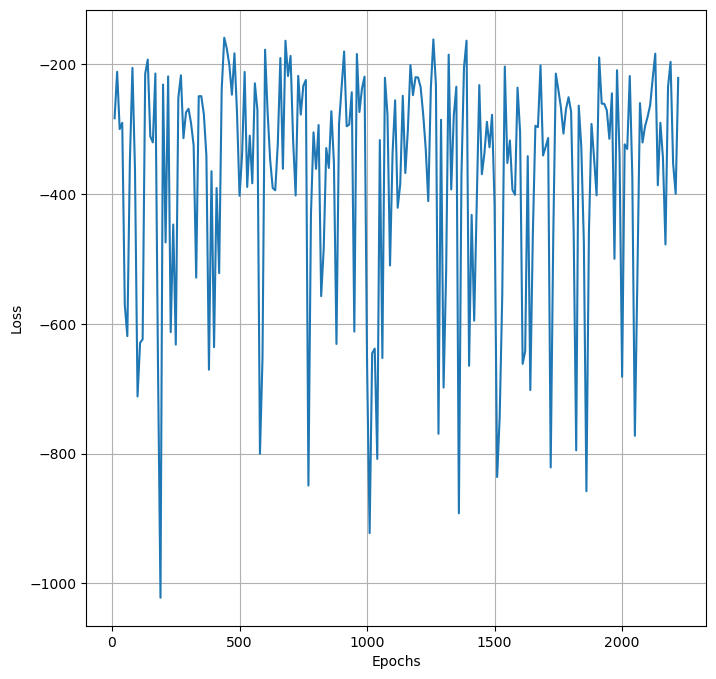

In [8]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [9]:
xs = pd.read_csv('Data/R'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/R'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [10]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=100)

In [11]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 2.611891e+02 | T: ((Array([-0.03297658,  0.04987594,  0.05111676, -0.0795758 , -0.08360953,
        0.03523766,  0.09591291, -0.05294995,  0.03440126, -0.02699032,
       -0.01079877,  0.1548233 , -0.12288535,  0.09844937, -0.15847734,
       -0.17472541, -0.04920641,  0.17291161,  0.11089695,  0.00400438,
        0.05829221,  0.0482319 , -0.04779638, -0.09158821, -0.11713029,
        0.05097277,  0.13741253,  0.0245199 , -0.07434447, -0.2336872 ,
       -0.01454249, -0.00153596, -0.05605038, -0.12750888, -0.11331541,
       -0.00674295,  0.03637171, -0.19953048, -0.12794945, -0.07927304,
        0.11526597, -0.11156766,  0.0069036 ,  0.08964557,  0.01451494,
       -0.09288984,  0.03338984,  0.05455242,  0.15708315, -0.08597107],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 2.347112e+02 | T: ((Array([-0.04287472,  0.03994492,  0.04118549, -0.08939222, -0.09340898,
        0.0253098 ,  0.08597484, -0.06282727,  0.0244736 , 

Step 7 | T: 1.409419e+02 | T: ((Array([-0.09648132, -0.01606642, -0.01484231, -0.13599266, -0.13847038,
       -0.03048471,  0.02949166, -0.11475778, -0.0313071 , -0.09084278,
       -0.07537504,  0.0880418 , -0.12132917,  0.03200819, -0.10753313,
       -0.11682542, -0.111417  ,  0.10605086,  0.0443649 , -0.06104687,
       -0.0077584 , -0.01768789, -0.11014628, -0.14216498, -0.12990919,
       -0.01498437,  0.07071879, -0.04100916, -0.13236314, -0.16930765,
       -0.0789741 , -0.06642537, -0.11748343, -0.1201069 , -0.13509394,
       -0.07146358, -0.02936935, -0.1373986 , -0.12067629, -0.13579422,
        0.04870451, -0.13706021, -0.05822592,  0.02327587, -0.05080184,
       -0.14256461, -0.03230137, -0.01145154,  0.09029112, -0.13975476],      dtype=float32), Array(0.27601084, dtype=float32)), Array([0.], dtype=float32))
Step 8 | T: 1.320495e+02 | T: ((Array([-0.10394324, -0.02452989, -0.02331252, -0.14061007, -0.14251548,
       -0.03885918,  0.02083603, -0.12151621, -0.03967591, 

Step 17 | T: 8.821709e+01 | T: ((Array([-0.1468384 , -0.08603655, -0.08495036, -0.1460128 , -0.14279273,
       -0.09863801, -0.04441934, -0.15296057, -0.09934482, -0.1438766 ,
       -0.1341453 ,  0.01119694, -0.12828591, -0.04206605, -0.11419339,
       -0.10048188, -0.15235868,  0.02856608, -0.03045224, -0.12367592,
       -0.07862174, -0.08747169, -0.15205704, -0.13467723, -0.11990894,
       -0.08507653, -0.00541478, -0.10756664, -0.1492544 , -0.11211599,
       -0.13658223, -0.12773304, -0.15322201, -0.12521827, -0.11645554,
       -0.13140017, -0.09767716, -0.0969994 , -0.12430884, -0.14622909,
       -0.02635251, -0.11599659, -0.12149603, -0.05021263, -0.11561002,
       -0.1331704 , -0.10019741, -0.08193   ,  0.01336122, -0.14061965],      dtype=float32), Array(0.35013556, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 8.565061e+01 | T: ((Array([-0.14905663, -0.09119903, -0.0901351 , -0.14414889, -0.14060664,
       -0.10350874, -0.05022333, -0.15364304, -0.10419708

Step 27 | T: 7.115897e+01 | T: ((Array([-0.15315902, -0.12430196, -0.1234864 , -0.12479413, -0.12135814,
       -0.13339308, -0.09062614, -0.14603743, -0.13388006, -0.15376562,
       -0.15252331, -0.04116672, -0.12288456, -0.08861051, -0.13298595,
       -0.12037333, -0.14801437, -0.02516257, -0.07854108, -0.1484196 ,
       -0.11864953, -0.12537248, -0.14867997, -0.11628044, -0.12921011,
       -0.12358137, -0.05626971, -0.13932459, -0.12952946, -0.09618988,
       -0.15314661, -0.15023763, -0.14416985, -0.12546794, -0.12828295,
       -0.1516466 , -0.13272677, -0.10187256, -0.12607713, -0.12506329,
       -0.07494267, -0.12670425, -0.14734803, -0.09554849, -0.14417942,
       -0.1158146 , -0.13446374, -0.12119552, -0.03918343, -0.11954629],      dtype=float32), Array(0.40144312, dtype=float32)), Array([0.], dtype=float32))
Step 28 | T: 7.016215e+01 | T: ((Array([-0.15237479, -0.12668253, -0.12589799, -0.1230971 , -0.11994704,
       -0.13537665, -0.093939  , -0.14435126, -0.1358391 

Step 37 | T: 6.392034e+01 | T: ((Array([-0.14094128, -0.1395568 , -0.13905376, -0.11616091, -0.11630398,
       -0.1447054 , -0.11553767, -0.12920476, -0.14495242, -0.14359678,
       -0.14834067, -0.07420722, -0.12535058, -0.11395408, -0.1303959 ,
       -0.13242039, -0.1316409 , -0.06007307, -0.10588175, -0.14967097,
       -0.13596104, -0.1402082 , -0.13254209, -0.11945239, -0.12258418,
       -0.13911264, -0.08727072, -0.14743775, -0.11721988, -0.10225452,
       -0.14756024, -0.1494893 , -0.12716794, -0.12394121, -0.12583104,
       -0.14897804, -0.14436187, -0.11836085, -0.12361543, -0.11618634,
       -0.10293891, -0.12734574, -0.14962389, -0.11935341, -0.14906286,
       -0.1203095 , -0.14524375, -0.13761123, -0.07247056, -0.11683299],      dtype=float32), Array(0.43696836, dtype=float32)), Array([0.], dtype=float32))
Step 38 | T: 6.343806e+01 | T: ((Array([-0.13950464, -0.14022711, -0.13975412, -0.11623689, -0.11670982,
       -0.1450045 , -0.11717187, -0.1278135 , -0.1452294 

Step 47 | T: 6.016846e+01 | T: ((Array([-0.12824921, -0.14193769, -0.1417069 , -0.12086544, -0.12289602,
       -0.14378902, -0.12699755, -0.11981978, -0.14384387, -0.13099386,
       -0.13752463, -0.09425839, -0.12483678, -0.12585023, -0.12273109,
       -0.13050994, -0.12112662, -0.08220744, -0.11982542, -0.14166452,
       -0.14016157, -0.14222643, -0.12166946, -0.12701765, -0.12479517,
       -0.14173426, -0.1050934 , -0.14404508, -0.11886256, -0.11381438,
       -0.1361761 , -0.14034827, -0.11891945, -0.1254113 , -0.12265024,
       -0.13885418, -0.14370556, -0.12866451, -0.12553701, -0.12072733,
       -0.11756552, -0.12258143, -0.1422388 , -0.12970689, -0.14337079,
       -0.12752551, -0.14390244, -0.14101113, -0.09279431, -0.12418221],      dtype=float32), Array(0.46279907, dtype=float32)), Array([0.], dtype=float32))
Step 48 | T: 5.989342e+01 | T: ((Array([-0.12728727, -0.14177804, -0.14157037, -0.1215506 , -0.12358402,
       -0.14335805, -0.12765472, -0.11942953, -0.14339764

Step 57 | T: 5.791180e+01 | T: ((Array([-0.12167621, -0.13874944, -0.13871111, -0.12628253, -0.12729032,
       -0.13841572, -0.13100486, -0.11923302, -0.13835233, -0.12332594,
       -0.128466  , -0.10622931, -0.12442634, -0.13023816, -0.12211597,
       -0.12486344, -0.11919442, -0.09624272, -0.12603603, -0.13290577,
       -0.13829061, -0.13878447, -0.11924928, -0.12728263, -0.12555352,
       -0.13871612, -0.11490985, -0.13723983, -0.12448279, -0.12266441,
       -0.12725571, -0.13133712, -0.11947851, -0.12427995, -0.12560317,
       -0.12975262, -0.13849398, -0.13032569, -0.12427945, -0.12618932,
       -0.12439691, -0.1248595 , -0.13366805, -0.13276172, -0.1354473 ,
       -0.12697099, -0.13826923, -0.13855174, -0.10503264, -0.12761036],      dtype=float32), Array(0.4828575, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 5.773443e+01 | T: ((Array([-0.12136773, -0.1383087 , -0.13828486, -0.12656185, -0.12739445,
       -0.13781998, -0.13115932, -0.11947238, -0.13774882,

Step 67 | T: 5.639901e+01 | T: ((Array([-0.12066108, -0.1341894 , -0.13426   , -0.12691817, -0.12642267,
       -0.13276641, -0.13138305, -0.12240296, -0.13265368, -0.12105692,
       -0.12360077, -0.11336263, -0.12508926, -0.13091461, -0.12493039,
       -0.12262773, -0.12171324, -0.1052747 , -0.12817922, -0.12683932,
       -0.13450918, -0.13408355, -0.12149297, -0.12442529, -0.12408364,
       -0.13425227, -0.12011999, -0.13109122, -0.12684302, -0.1268668 ,
       -0.12287224, -0.12559316, -0.12307195, -0.12506466, -0.12503192,
       -0.12444846, -0.13291411, -0.12766296, -0.12499962, -0.12693559,
       -0.12705323, -0.12551583, -0.12748906, -0.1324066 , -0.12914121,
       -0.12409569, -0.13251306, -0.1344133 , -0.11240895, -0.12592526],      dtype=float32), Array(0.49939525, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 5.627431e+01 | T: ((Array([-0.12075311, -0.13374704, -0.13382448, -0.12678131, -0.12619846,
       -0.13226597, -0.13131574, -0.1227358 , -0.13215137

Step 77 | T: 5.530734e+01 | T: ((Array([-0.12226434, -0.13020092, -0.1303137 , -0.12513633, -0.12442096,
       -0.12851165, -0.13030107, -0.12504661, -0.12839799, -0.12188413,
       -0.12221874, -0.11764485, -0.124493  , -0.13004607, -0.12577674,
       -0.12361439, -0.12444934, -0.1112157 , -0.12839822, -0.12385432,
       -0.13085824, -0.1300435 , -0.12422127, -0.12374188, -0.12500888,
       -0.13030091, -0.12277982, -0.12695883, -0.12594625, -0.12758791,
       -0.12197915, -0.12313727, -0.12550499, -0.12456486, -0.12426762,
       -0.1225696 , -0.12866329, -0.12493208, -0.12465202, -0.1251899 ,
       -0.12766613, -0.1243166 , -0.1242641 , -0.13081256, -0.12540953,
       -0.12381467, -0.1282585 , -0.13059786, -0.11690044, -0.1240631 ],      dtype=float32), Array(0.51364166, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 5.521454e+01 | T: ((Array([-0.12246404, -0.12986428, -0.1299785 , -0.12496971, -0.12429835,
       -0.1281804 , -0.13016163, -0.12520836, -0.12806839

Step 88 | T: 5.440961e+01 | T: ((Array([-0.12422164, -0.12717359, -0.12728381, -0.12409375, -0.12405467,
       -0.12573825, -0.12872234, -0.12584212, -0.12565212, -0.12365606,
       -0.12278544, -0.12044673, -0.12490536, -0.12861781, -0.12480173,
       -0.12504813, -0.12568222, -0.11553922, -0.12777779, -0.12304618,
       -0.12786731, -0.12702395, -0.1255952 , -0.12477298, -0.12472648,
       -0.12727116, -0.12415501, -0.12464781, -0.12450176, -0.12657747,
       -0.12288049, -0.12283628, -0.12588316, -0.12482506, -0.12498376,
       -0.12275863, -0.12585486, -0.12378187, -0.1247342 , -0.12410805,
       -0.12735263, -0.12477016, -0.12320265, -0.1288859 , -0.12374021,
       -0.1249277 , -0.12554781, -0.1275754 , -0.11989105, -0.12417313],      dtype=float32), Array(0.5274532, dtype=float32)), Array([0.], dtype=float32))
Step 89 | T: 5.433974e+01 | T: ((Array([-0.12435496, -0.12696928, -0.12707771, -0.124086  , -0.12410361,
       -0.12557203, -0.12858313, -0.1258273 , -0.12548903,

Step 99 | T: 5.372521e+01 | T: ((Array([-0.12517633, -0.12547341, -0.12555715, -0.12445183, -0.12473432,
       -0.12450209, -0.127329  , -0.12532419, -0.1244505 , -0.12483072,
       -0.12386599, -0.12209984, -0.12466475, -0.12730852, -0.12441348,
       -0.12523414, -0.12545666, -0.11841026, -0.12695858, -0.12345445,
       -0.12602778, -0.125362  , -0.12548651, -0.12508872, -0.12469595,
       -0.12554745, -0.12472215, -0.12391058, -0.12426685, -0.12537324,
       -0.12406018, -0.12353449, -0.12516238, -0.12475233, -0.12472787,
       -0.12369221, -0.12457316, -0.12407014, -0.12480293, -0.12443419,
       -0.12673305, -0.12488355, -0.12344939, -0.12731043, -0.12355173,
       -0.1250583 , -0.12438906, -0.12578613, -0.12169218, -0.12490434],      dtype=float32), Array(0.53978413, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 5.372521e+01 | T: (Array([-0.12517633, -0.12547341, -0.12555715, -0.12445183, -0.12473432,
       -0.12450209, -0.127329  , -0.12532419, -0.1244505 

In [12]:
mu_opt, T_opt = M.mlxt_hk(X_obs)

In [13]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.1239 -0.0659 0.0187 -0.1424 -0.0158 -0.1064 0.0009 -0.0224 0.0930 0.0212 -0.1513 0.0493 -0.0624 -0.0323 0.1661 0.0120 -0.0211 0.0038 -0.0059 0.1063 -0.0781 -0.0204 -0.1239 0.0522 0.1138 -0.0789 0.0333 -0.0365 -0.0038 0.1193 -0.1200 -0.0630 0.0271 0.1421 0.0906 0.0459 0.0284 0.0522 0.0910 -0.1029 0.0925 -0.1602 0.1160 0.0881 0.1057 -0.0430 -0.0132 0.0838 0.1497 0.0941 )
T = 0.5652


In [14]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgex[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( -0.1252 -0.1255 -0.1256 -0.1245 -0.1247 -0.1245 -0.1273 -0.1253 -0.1245 -0.1248 -0.1239 -0.1221 -0.1247 -0.1273 -0.1244 -0.1252 -0.1255 -0.1184 -0.1270 -0.1235 -0.1260 -0.1254 -0.1255 -0.1251 -0.1247 -0.1255 -0.1247 -0.1239 -0.1243 -0.1254 -0.1241 -0.1235 -0.1252 -0.1248 -0.1247 -0.1237 -0.1246 -0.1241 -0.1248 -0.1244 -0.1267 -0.1249 -0.1234 -0.1273 -0.1236 -0.1251 -0.1244 -0.1258 -0.1217 -0.1249 )
T = 0.5398


In [15]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[0]), ")")
print(f"T = {T_opt:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.1248 -0.0706 0.0275 -0.1513 -0.0203 -0.1035 0.0053 -0.0289 0.0866 0.0229 -0.1470 0.0456 -0.0624 -0.0363 0.1732 0.0165 -0.0249 0.0136 -0.0064 0.1021 -0.0760 -0.0388 -0.1188 0.0578 0.1105 -0.0762 0.0270 -0.0307 -0.0101 0.1211 -0.1162 -0.0667 0.0296 0.1399 0.0814 0.0477 0.0272 0.0558 0.0916 -0.1032 0.0908 -0.1519 0.1164 0.0831 0.1072 -0.0349 -0.0145 0.0867 0.1524 0.0968 )
T = 0.5007


In [16]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[0]-mu_bridgex[-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.0378 
 -T error = 0.0645
Bridge Diffusion mean: 
 -mean error = 1.1161 
 -T error = 0.0391


In [17]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

KeyboardInterrupt: 

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100, N=1)

# Circle

## Defining Manifold and Loading Score

In [4]:
M = S1(use_spherical_coords=True)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.])

using M.Exp for Logarithm


In [5]:
file_path = 'scores/S1/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [6]:
loss = jnp.load('scores/S1/'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


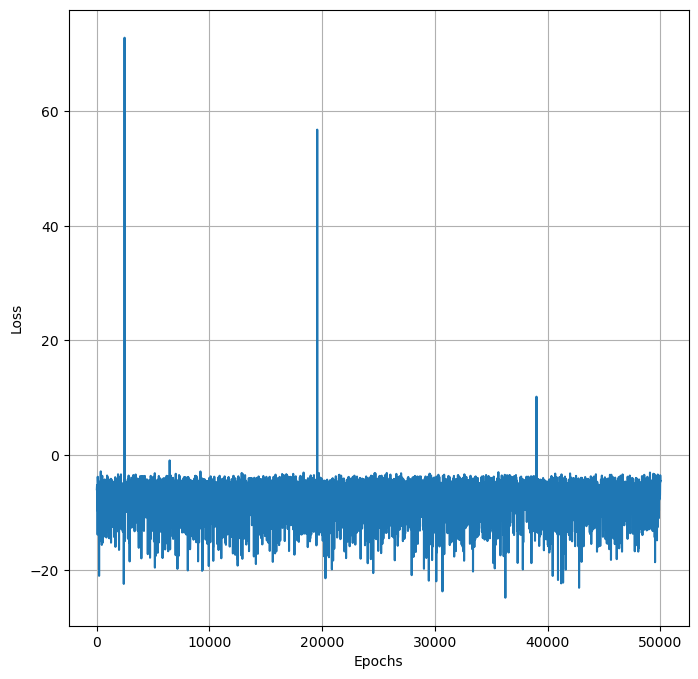

In [7]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [8]:
xs = pd.read_csv('Data/S1/xs.csv', header=None)
charts = pd.read_csv('Data/S1/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [9]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.01, max_iter=100)

In [10]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.556140e+01 | T: ((Array([-0.13024218], dtype=float32), Array(0.20999993, dtype=float32)), Array([1., 0.], dtype=float32))
Step 1 | T: 1.384183e+01 | T: ((Array([-0.12028404], dtype=float32), Array(0.21992145, dtype=float32)), Array([1., 0.], dtype=float32))
Final 1 | T: 1.384183e+01 | T: (Array([-0.12028404], dtype=float32), Array(0.21992145, dtype=float32))
Step 0 | T: 1.556140e+01 | T: ((Array([-0.13024218], dtype=float32), Array(0.20999993, dtype=float32)), Array([1., 0.], dtype=float32))
Step 1 | T: 1.384183e+01 | T: ((Array([-0.12028404], dtype=float32), Array(0.21992145, dtype=float32)), Array([1., 0.], dtype=float32))
Step 2 | T: 1.237897e+01 | T: ((Array([-0.11039155], dtype=float32), Array(0.22972058, dtype=float32)), Array([1., 0.], dtype=float32))
Step 3 | T: 1.113019e+01 | T: ((Array([-0.1005855], dtype=float32), Array(0.2393599, dtype=float32)), Array([1., 0.], dtype=float32))
Step 4 | T: 1.006012e+01 | T: ((Array([-0.0908839], dtype=float32), Array(0.2488082

Step 60 | T: 1.454821e+00 | T: ((Array([0.24940015], dtype=float32), Array(0.47070065, dtype=float32)), Array([1., 0.], dtype=float32))
Step 61 | T: 1.436850e+00 | T: ((Array([0.2534189], dtype=float32), Array(0.47192585, dtype=float32)), Array([1., 0.], dtype=float32))
Step 62 | T: 1.419348e+00 | T: ((Array([0.25741065], dtype=float32), Array(0.4731185, dtype=float32)), Array([1., 0.], dtype=float32))
Step 63 | T: 1.402293e+00 | T: ((Array([0.26137638], dtype=float32), Array(0.47427985, dtype=float32)), Array([1., 0.], dtype=float32))
Step 64 | T: 1.385663e+00 | T: ((Array([0.2653171], dtype=float32), Array(0.47541103, dtype=float32)), Array([1., 0.], dtype=float32))
Step 65 | T: 1.369437e+00 | T: ((Array([0.26923373], dtype=float32), Array(0.4765131, dtype=float32)), Array([1., 0.], dtype=float32))
Step 66 | T: 1.353597e+00 | T: ((Array([0.27312708], dtype=float32), Array(0.47758707, dtype=float32)), Array([1., 0.], dtype=float32))
Step 67 | T: 1.338125e+00 | T: ((Array([0.27699795],

In [23]:
def gradt_log_opt(x,y,t):
    
    s1_val = M.grady_log_hk(x,y,t)
    s2_val = jacfwdx(lambda y: M.grady_log_hk(x,y,t))(y)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

In [24]:
diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t), s2_model = gradt_log_opt, method="Gradient")
mu_opt, T_opt, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]))

In [25]:
mu_smchart = M.F((mu_sm[0][-1], mu_sm[1][-1]))

In [26]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_smchart), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 1.0000 0.0058 )
T = 0.1861


In [27]:
mu_bridge = M.F((mu_bridgex[-1], mu_bridgechart[-1]))

In [28]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridge), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.9241 0.3821 )
T = 0.5014


In [29]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[1][-1]), ")")
print(f"T = {T_opt[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 1.0000 0.0079 )
T = 0.0587


In [30]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_bridgechart[-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.0021 
 -T error = 0.1274
Bridge Diffusion mean: 
 -mean error = 0.0079 
 -T error = 0.4427


In [31]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

295 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%timeit M.diffusion_mean(X_obs,num_steps=100, N=1)

Step 0 | T: 1.556140e+01 | T: ((Array([-0.13024218], dtype=float32), Array(0.20999993, dtype=float32)), Array([1., 0.], dtype=float32))
Step 1 | T: 1.384183e+01 | T: ((Array([-0.12028404], dtype=float32), Array(0.21992145, dtype=float32)), Array([1., 0.], dtype=float32))
Step 2 | T: 1.237897e+01 | T: ((Array([-0.11039155], dtype=float32), Array(0.22972058, dtype=float32)), Array([1., 0.], dtype=float32))
Step 3 | T: 1.113019e+01 | T: ((Array([-0.1005855], dtype=float32), Array(0.2393599, dtype=float32)), Array([1., 0.], dtype=float32))
Step 4 | T: 1.006012e+01 | T: ((Array([-0.0908839], dtype=float32), Array(0.24880826, dtype=float32)), Array([1., 0.], dtype=float32))
Step 5 | T: 9.139505e+00 | T: ((Array([-0.08130208], dtype=float32), Array(0.25804043, dtype=float32)), Array([1., 0.], dtype=float32))
Step 6 | T: 8.344177e+00 | T: ((Array([-0.07185281], dtype=float32), Array(0.2670365, dtype=float32)), Array([1., 0.], dtype=float32))
Step 7 | T: 7.654189e+00 | T: ((Array([-0.06254657],

Step 62 | T: 1.419348e+00 | T: ((Array([0.25741065], dtype=float32), Array(0.47311848, dtype=float32)), Array([1., 0.], dtype=float32))
Step 63 | T: 1.402293e+00 | T: ((Array([0.26137638], dtype=float32), Array(0.47427982, dtype=float32)), Array([1., 0.], dtype=float32))
Step 64 | T: 1.385663e+00 | T: ((Array([0.2653171], dtype=float32), Array(0.475411, dtype=float32)), Array([1., 0.], dtype=float32))
Step 65 | T: 1.369438e+00 | T: ((Array([0.26923373], dtype=float32), Array(0.47651306, dtype=float32)), Array([1., 0.], dtype=float32))
Step 66 | T: 1.353597e+00 | T: ((Array([0.27312708], dtype=float32), Array(0.47758704, dtype=float32)), Array([1., 0.], dtype=float32))
Step 67 | T: 1.338125e+00 | T: ((Array([0.27699795], dtype=float32), Array(0.47863388, dtype=float32)), Array([1., 0.], dtype=float32))
Step 68 | T: 1.323005e+00 | T: ((Array([0.28084713], dtype=float32), Array(0.47965446, dtype=float32)), Array([1., 0.], dtype=float32))
Step 69 | T: 1.308221e+00 | T: ((Array([0.2846753],

Step 25 | T: 2.882330e+00 | T: ((Array([0.07728496], dtype=float32), Array(0.38890606, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 2.789116e+00 | T: ((Array([0.08361785], dtype=float32), Array(0.39307362, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 2.702716e+00 | T: ((Array([0.08982517], dtype=float32), Array(0.39706972, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 2.622452e+00 | T: ((Array([0.0959115], dtype=float32), Array(0.4009021, dtype=float32)), Array([1., 0.], dtype=float32))
Step 29 | T: 2.547718e+00 | T: ((Array([0.1018814], dtype=float32), Array(0.40457824, dtype=float32)), Array([1., 0.], dtype=float32))
Step 30 | T: 2.477981e+00 | T: ((Array([0.1077394], dtype=float32), Array(0.4081054, dtype=float32)), Array([1., 0.], dtype=float32))
Step 31 | T: 2.412769e+00 | T: ((Array([0.11348994], dtype=float32), Array(0.41149062, dtype=float32)), Array([1., 0.], dtype=float32))
Step 32 | T: 2.351662e+00 | T: ((Array([0.11913741], 

Step 88 | T: 1.076424e+00 | T: ((Array([0.35411316], dtype=float32), Array(0.49555457, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.066236e+00 | T: ((Array([0.3576207], dtype=float32), Array(0.49616033, dtype=float32)), Array([1., 0.], dtype=float32))
Step 90 | T: 1.056208e+00 | T: ((Array([0.3611154], dtype=float32), Array(0.4967506, dtype=float32)), Array([1., 0.], dtype=float32))
Step 91 | T: 1.046333e+00 | T: ((Array([0.3645975], dtype=float32), Array(0.4973256, dtype=float32)), Array([1., 0.], dtype=float32))
Step 92 | T: 1.036608e+00 | T: ((Array([0.36806718], dtype=float32), Array(0.49788558, dtype=float32)), Array([1., 0.], dtype=float32))
Step 93 | T: 1.027030e+00 | T: ((Array([0.37152457], dtype=float32), Array(0.4984308, dtype=float32)), Array([1., 0.], dtype=float32))
Step 94 | T: 1.017593e+00 | T: ((Array([0.37496987], dtype=float32), Array(0.49896142, dtype=float32)), Array([1., 0.], dtype=float32))
Step 95 | T: 1.008293e+00 | T: ((Array([0.37840325], d

Step 50 | T: 1.667072e+00 | T: ((Array([0.20745276], dtype=float32), Array(0.45632863, dtype=float32)), Array([1., 0.], dtype=float32))
Step 51 | T: 1.642617e+00 | T: ((Array([0.21181345], dtype=float32), Array(0.457966, dtype=float32)), Array([1., 0.], dtype=float32))
Step 52 | T: 1.619001e+00 | T: ((Array([0.21613283], dtype=float32), Array(0.45955345, dtype=float32)), Array([1., 0.], dtype=float32))
Step 53 | T: 1.596170e+00 | T: ((Array([0.22041275], dtype=float32), Array(0.46109325, dtype=float32)), Array([1., 0.], dtype=float32))
Step 54 | T: 1.574079e+00 | T: ((Array([0.2246549], dtype=float32), Array(0.4625875, dtype=float32)), Array([1., 0.], dtype=float32))
Step 55 | T: 1.552683e+00 | T: ((Array([0.22886093], dtype=float32), Array(0.46403822, dtype=float32)), Array([1., 0.], dtype=float32))
Step 56 | T: 1.531941e+00 | T: ((Array([0.23303238], dtype=float32), Array(0.46544728, dtype=float32)), Array([1., 0.], dtype=float32))
Step 57 | T: 1.511817e+00 | T: ((Array([0.23717068],

Step 10 | T: 6.065063e+00 | T: ((Array([-0.03556131], dtype=float32), Array(0.3004177, dtype=float32)), Array([1., 0.], dtype=float32))
Step 11 | T: 5.657508e+00 | T: ((Array([-0.02689395], dtype=float32), Array(0.30808225, dtype=float32)), Array([1., 0.], dtype=float32))
Step 12 | T: 5.296598e+00 | T: ((Array([-0.01839517], dtype=float32), Array(0.31547198, dtype=float32)), Array([1., 0.], dtype=float32))
Step 13 | T: 4.975773e+00 | T: ((Array([-0.01006602], dtype=float32), Array(0.32258916, dtype=float32)), Array([1., 0.], dtype=float32))
Step 14 | T: 4.689525e+00 | T: ((Array([-0.00190655], dtype=float32), Array(0.32943752, dtype=float32)), Array([1., 0.], dtype=float32))
Step 15 | T: 4.433213e+00 | T: ((Array([0.00608404], dtype=float32), Array(0.33602205, dtype=float32)), Array([1., 0.], dtype=float32))
Step 16 | T: 4.202914e+00 | T: ((Array([0.01390731], dtype=float32), Array(0.3423486, dtype=float32)), Array([1., 0.], dtype=float32))
Step 17 | T: 3.995296e+00 | T: ((Array([0.021

Step 73 | T: 1.252176e+00 | T: ((Array([0.29979077], dtype=float32), Array(0.48439133, dtype=float32)), Array([1., 0.], dtype=float32))
Step 74 | T: 1.238876e+00 | T: ((Array([0.30352318], dtype=float32), Array(0.4852704, dtype=float32)), Array([1., 0.], dtype=float32))
Step 75 | T: 1.225838e+00 | T: ((Array([0.30723807], dtype=float32), Array(0.48612818, dtype=float32)), Array([1., 0.], dtype=float32))
Step 76 | T: 1.213054e+00 | T: ((Array([0.31093588], dtype=float32), Array(0.48696518, dtype=float32)), Array([1., 0.], dtype=float32))
Step 77 | T: 1.200513e+00 | T: ((Array([0.31461704], dtype=float32), Array(0.48778194, dtype=float32)), Array([1., 0.], dtype=float32))
Step 78 | T: 1.188206e+00 | T: ((Array([0.31828198], dtype=float32), Array(0.48857898, dtype=float32)), Array([1., 0.], dtype=float32))
Step 79 | T: 1.176126e+00 | T: ((Array([0.32193106], dtype=float32), Array(0.48935673, dtype=float32)), Array([1., 0.], dtype=float32))
Step 80 | T: 1.164265e+00 | T: ((Array([0.3255646

Step 34 | T: 2.240310e+00 | T: ((Array([0.1301401], dtype=float32), Array(0.42086107, dtype=float32)), Array([1., 0.], dtype=float32))
Step 35 | T: 2.189436e+00 | T: ((Array([0.13550356], dtype=float32), Array(0.42374367, dtype=float32)), Array([1., 0.], dtype=float32))
Step 36 | T: 2.141398e+00 | T: ((Array([0.1407804], dtype=float32), Array(0.42651558, dtype=float32)), Array([1., 0.], dtype=float32))
Step 37 | T: 2.095955e+00 | T: ((Array([0.14597443], dtype=float32), Array(0.4291823, dtype=float32)), Array([1., 0.], dtype=float32))
Step 38 | T: 2.052896e+00 | T: ((Array([0.15108931], dtype=float32), Array(0.43174902, dtype=float32)), Array([1., 0.], dtype=float32))
Step 39 | T: 2.012025e+00 | T: ((Array([0.1561286], dtype=float32), Array(0.43422073, dtype=float32)), Array([1., 0.], dtype=float32))
Step 40 | T: 1.973169e+00 | T: ((Array([0.16109572], dtype=float32), Array(0.43660215, dtype=float32)), Array([1., 0.], dtype=float32))
Step 41 | T: 1.936169e+00 | T: ((Array([0.16599394],

Step 95 | T: 1.008293e+00 | T: ((Array([0.3784033], dtype=float32), Array(0.49947765, dtype=float32)), Array([1., 0.], dtype=float32))
Step 96 | T: 9.991281e-01 | T: ((Array([0.38182488], dtype=float32), Array(0.49997976, dtype=float32)), Array([1., 0.], dtype=float32))
Step 97 | T: 9.900938e-01 | T: ((Array([0.3852348], dtype=float32), Array(0.5004679, dtype=float32)), Array([1., 0.], dtype=float32))
Step 98 | T: 9.811863e-01 | T: ((Array([0.38863322], dtype=float32), Array(0.50094223, dtype=float32)), Array([1., 0.], dtype=float32))
Step 99 | T: 9.724031e-01 | T: ((Array([0.39202026], dtype=float32), Array(0.501403, dtype=float32)), Array([1., 0.], dtype=float32))
Final 99 | T: 9.724031e-01 | T: (Array([0.39202026], dtype=float32), Array(0.501403, dtype=float32))
Step 0 | T: 1.556140e+01 | T: ((Array([-0.13024218], dtype=float32), Array(0.20999993, dtype=float32)), Array([1., 0.], dtype=float32))
Step 1 | T: 1.384183e+01 | T: ((Array([-0.12028404], dtype=float32), Array(0.21992145, d

Step 58 | T: 1.492276e+00 | T: ((Array([0.24127722], dtype=float32), Array(0.46814737, dtype=float32)), Array([1., 0.], dtype=float32))
Step 59 | T: 1.473288e+00 | T: ((Array([0.2453533], dtype=float32), Array(0.46944162, dtype=float32)), Array([1., 0.], dtype=float32))
Step 60 | T: 1.454821e+00 | T: ((Array([0.24940014], dtype=float32), Array(0.47070065, dtype=float32)), Array([1., 0.], dtype=float32))
Step 61 | T: 1.436850e+00 | T: ((Array([0.2534189], dtype=float32), Array(0.47192585, dtype=float32)), Array([1., 0.], dtype=float32))
Step 62 | T: 1.419348e+00 | T: ((Array([0.25741065], dtype=float32), Array(0.4731185, dtype=float32)), Array([1., 0.], dtype=float32))
Step 63 | T: 1.402293e+00 | T: ((Array([0.26137638], dtype=float32), Array(0.47427985, dtype=float32)), Array([1., 0.], dtype=float32))
Step 64 | T: 1.385663e+00 | T: ((Array([0.2653171], dtype=float32), Array(0.47541103, dtype=float32)), Array([1., 0.], dtype=float32))
Step 65 | T: 1.369437e+00 | T: ((Array([0.2692337], 

Step 21 | T: 3.340694e+00 | T: ((Array([0.0506064], dtype=float32), Array(0.37036142, dtype=float32)), Array([1., 0.], dtype=float32))
Step 22 | T: 3.211235e+00 | T: ((Array([0.05748706], dtype=float32), Array(0.37529507, dtype=float32)), Array([1., 0.], dtype=float32))
Step 23 | T: 3.092440e+00 | T: ((Array([0.06422409], dtype=float32), Array(0.3800249, dtype=float32)), Array([1., 0.], dtype=float32))
Step 24 | T: 2.983144e+00 | T: ((Array([0.07082188], dtype=float32), Array(0.38455918, dtype=float32)), Array([1., 0.], dtype=float32))
Step 25 | T: 2.882331e+00 | T: ((Array([0.07728495], dtype=float32), Array(0.38890606, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 2.789115e+00 | T: ((Array([0.08361784], dtype=float32), Array(0.39307362, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 2.702717e+00 | T: ((Array([0.08982515], dtype=float32), Array(0.39706972, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 2.622452e+00 | T: ((Array([0.09591148

Step 83 | T: 1.129919e+00 | T: ((Array([0.33637586], dtype=float32), Array(0.49228343, dtype=float32)), Array([1., 0.], dtype=float32))
Step 84 | T: 1.118862e+00 | T: ((Array([0.33995074], dtype=float32), Array(0.49297094, dtype=float32)), Array([1., 0.], dtype=float32))
Step 85 | T: 1.107988e+00 | T: ((Array([0.34351167], dtype=float32), Array(0.4936415, dtype=float32)), Array([1., 0.], dtype=float32))
Step 86 | T: 1.097295e+00 | T: ((Array([0.3470589], dtype=float32), Array(0.49429542, dtype=float32)), Array([1., 0.], dtype=float32))
Step 87 | T: 1.086775e+00 | T: ((Array([0.35059267], dtype=float32), Array(0.494933, dtype=float32)), Array([1., 0.], dtype=float32))
Step 88 | T: 1.076424e+00 | T: ((Array([0.35411322], dtype=float32), Array(0.49555457, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.066236e+00 | T: ((Array([0.35762075], dtype=float32), Array(0.49616033, dtype=float32)), Array([1., 0.], dtype=float32))
Step 90 | T: 1.056208e+00 | T: ((Array([0.36111546],

Step 46 | T: 1.774482e+00 | T: ((Array([0.18955693], dtype=float32), Array(0.4492298, dtype=float32)), Array([1., 0.], dtype=float32))
Step 47 | T: 1.746056e+00 | T: ((Array([0.19410312], dtype=float32), Array(0.45109233, dtype=float32)), Array([1., 0.], dtype=float32))
Step 48 | T: 1.718727e+00 | T: ((Array([0.19859968], dtype=float32), Array(0.45289442, dtype=float32)), Array([1., 0.], dtype=float32))
Step 49 | T: 1.692422e+00 | T: ((Array([0.20304884], dtype=float32), Array(0.45463896, dtype=float32)), Array([1., 0.], dtype=float32))
Step 50 | T: 1.667072e+00 | T: ((Array([0.20745276], dtype=float32), Array(0.45632863, dtype=float32)), Array([1., 0.], dtype=float32))
Step 51 | T: 1.642617e+00 | T: ((Array([0.21181345], dtype=float32), Array(0.457966, dtype=float32)), Array([1., 0.], dtype=float32))
Step 52 | T: 1.619001e+00 | T: ((Array([0.21613283], dtype=float32), Array(0.45955345, dtype=float32)), Array([1., 0.], dtype=float32))
Step 53 | T: 1.596170e+00 | T: ((Array([0.22041275]

# n-Sphere

## Defining Manifold and Loading Score

In [94]:
N = 20

In [95]:
M = nSphere(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*N)

using M.Exp for Logarithm


In [96]:
file_path = 'scores/S'+str(N)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [97]:
loss = jnp.load('scores/S'+str(N)+'/'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  300


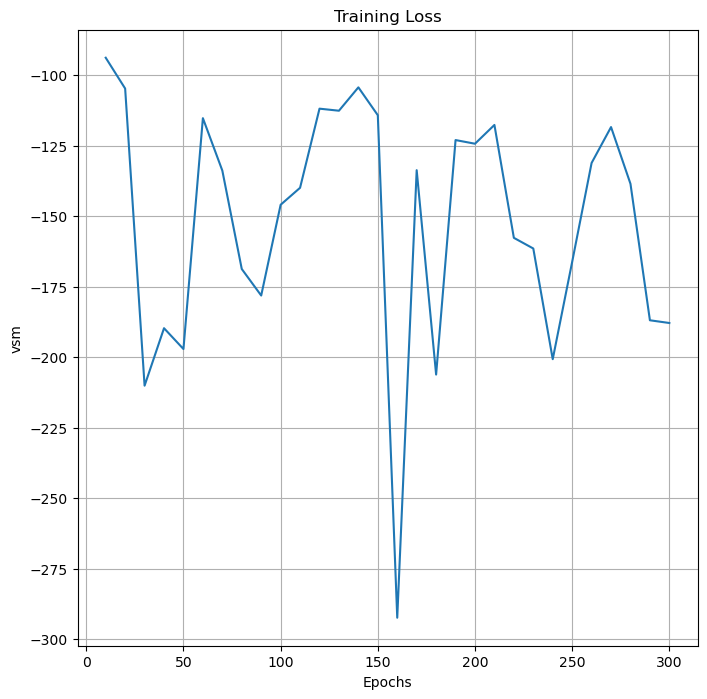

In [98]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [99]:
xs = pd.read_csv('Data/S'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/S'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [100]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [101]:
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.1, max_iter=100)

In [102]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 5.329305e+00 | T: ((Array([-4.7136695e-10, -2.5090401e-09,  1.4598527e-09,  8.2888363e-10,
        3.1430574e-09, -1.7479920e-09, -1.3536159e-09,  2.1282034e-09,
       -3.0270542e-10, -5.7960108e-09, -2.0288411e-09, -4.0548969e-09,
       -9.8068043e-10, -3.6702517e-09, -1.0452652e-09,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  7.4505806e-09, -0.0000000e+00],      dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.27831095, -0.03747457, -0.20965488,  0.1293238 ,  0.07870455,
        0.16978699, -0.07292849, -0.03915123,  0.11639494, -0.13160181,
       -0.21171647, -0.1748439 , -0.17255081, -0.04406209, -0.09614064,
       -0.0901813 ,  0.16596144, -0.02023277, -0.3091485 ,  0.1306341 ,
        0.72294044], dtype=float32))
Step 1 | T: -1.852028e-02 | T: ((Array([-1.0217426e-03, -3.2653610e-05, -9.1129337e-03, -4.9442840e-03,
        3.1620122e-03, -8.7301936e-03, -9.9950517e-03,  6.0362201e-03,
        7.1743121e-03,  7.7297874e-03,  5.0969552e-03,  

Step 9 | T: -6.496583e+00 | T: ((Array([ 1.6573587e-10,  1.7692940e-09,  2.7225000e-11, -1.2192052e-09,
       -2.1568872e-10,  4.9023043e-09,  6.0142078e-09, -8.1489944e-09,
        9.0300478e-10,  1.8039206e-09,  2.7987692e-09,  3.3445033e-09,
       -2.2387212e-09,  1.7202790e-09,  3.5150478e-09,  4.3368087e-18,
       -3.4694470e-18,  7.4505806e-09, -3.7252903e-09, -0.0000000e+00],      dtype=float32), Array(0.2888397, dtype=float32)), Array([ 0.21509287, -0.08760159, -0.27376696, -0.00569656,  0.0812643 ,
        0.266719  , -0.19297211, -0.18870226,  0.23831445, -0.07180503,
       -0.11390205, -0.16508982, -0.09042598,  0.07209729, -0.05743126,
       -0.22491756,  0.02827089, -0.03350789, -0.22292544,  0.0853924 ,
        0.7015283 ], dtype=float32))
Step 10 | T: -6.903070e+00 | T: ((Array([-8.5897220e-05, -5.0437767e-03, -5.5000624e-03,  6.5977086e-04,
        6.1165979e-03, -4.1377111e-03, -7.0851916e-03,  6.6029700e-03,
        1.0183183e-03,  2.9531380e-03, -1.8424371e-03, 

Step 21 | T: -7.391987e+00 | T: ((Array([-1.1267432e-03, -2.3861848e-02, -3.2974735e-02, -1.4273799e-05,
        3.0549731e-02, -8.6060269e-03, -3.9764564e-02,  3.0958215e-02,
        4.2262808e-03,  1.7267143e-02, -7.5779590e-03,  8.3022108e-03,
        1.2484539e-02,  1.3352459e-03, -2.1647850e-02, -3.7799932e-02,
       -2.1744350e-03,  9.9936752e-03,  1.7444821e-04, -1.5286120e-02],      dtype=float32), Array(0.34452698, dtype=float32)), Array([ 0.21509287, -0.08760159, -0.27376696, -0.00569656,  0.0812643 ,
        0.266719  , -0.19297211, -0.18870226,  0.23831445, -0.07180503,
       -0.11390205, -0.16508982, -0.09042598,  0.07209729, -0.05743126,
       -0.22491756,  0.02827089, -0.03350789, -0.22292544,  0.0853924 ,
        0.7015283 ], dtype=float32))
Step 22 | T: -7.410653e+00 | T: ((Array([-0.00078653, -0.02159971, -0.03135288, -0.00030831,  0.02793965,
       -0.00599326, -0.03733367,  0.02789281,  0.00356   ,  0.01620575,
       -0.00654195,  0.00729507,  0.01013538,  0.00

Step 33 | T: -7.376630e+00 | T: ((Array([-0.00206787, -0.00215854, -0.00623699,  0.00145829,  0.00349969,
       -0.00865146, -0.00659232,  0.00342481,  0.00132289,  0.00243046,
       -0.00173031,  0.00093243,  0.00414172,  0.00075527, -0.00408866,
       -0.0109656 , -0.00232557,  0.00175674, -0.00015298, -0.00978035],      dtype=float32), Array(0.35702166, dtype=float32)), Array([ 0.21509287, -0.08760159, -0.27376696, -0.00569656,  0.0812643 ,
        0.266719  , -0.19297211, -0.18870226,  0.23831445, -0.07180503,
       -0.11390205, -0.16508982, -0.09042598,  0.07209729, -0.05743126,
       -0.22491756,  0.02827089, -0.03350789, -0.22292544,  0.0853924 ,
        0.7015283 ], dtype=float32))
Step 34 | T: -7.376097e+00 | T: ((Array([-0.00174003, -0.00262859, -0.00545701,  0.00123203,  0.00385603,
       -0.00980864, -0.00606516,  0.00422347,  0.00173864,  0.00229057,
       -0.00226816,  0.00137274,  0.00549735,  0.000896  , -0.00580861,
       -0.00948011, -0.00255717,  0.00145327, 

Step 45 | T: -7.412128e+00 | T: ((Array([-0.00207608, -0.01445258, -0.01514958,  0.00109948,  0.01819357,
       -0.00458182, -0.02021611,  0.01964998,  0.00258565,  0.00938246,
       -0.00449048,  0.00539658,  0.0073584 ,  0.00060305, -0.01477536,
       -0.01417814, -0.00206846,  0.00414448,  0.00017868, -0.00849981],      dtype=float32), Array(0.3498474, dtype=float32)), Array([ 0.21509287, -0.08760159, -0.27376696, -0.00569656,  0.0812643 ,
        0.266719  , -0.19297211, -0.18870226,  0.23831445, -0.07180503,
       -0.11390205, -0.16508982, -0.09042598,  0.07209729, -0.05743126,
       -0.22491756,  0.02827089, -0.03350789, -0.22292544,  0.0853924 ,
        0.7015283 ], dtype=float32))
Step 46 | T: -7.429636e+00 | T: ((Array([-0.00188699, -0.0145946 , -0.01625439,  0.00123938,  0.01854465,
       -0.00459289, -0.02133512,  0.01964588,  0.00235592,  0.00980823,
       -0.00419384,  0.00518359,  0.00660718,  0.00058655, -0.01379266,
       -0.01551233, -0.00168412,  0.00452463,  

Step 57 | T: -7.458913e+00 | T: ((Array([-2.2128373e-03, -9.1048917e-03, -1.6093509e-02,  5.7070941e-04,
        1.2392817e-02, -8.5002882e-03, -1.8570246e-02,  1.2207027e-02,
        2.5510108e-03,  7.5206268e-03, -4.0093893e-03,  3.2521135e-03,
        7.9626022e-03,  8.9374842e-04, -1.0276590e-02, -2.0730346e-02,
       -1.3282528e-03,  4.8140385e-03, -2.7437720e-05, -1.1634518e-02],      dtype=float32), Array(0.3383581, dtype=float32)), Array([ 0.21509287, -0.08760159, -0.27376696, -0.00569656,  0.0812643 ,
        0.266719  , -0.19297211, -0.18870226,  0.23831445, -0.07180503,
       -0.11390205, -0.16508982, -0.09042598,  0.07209729, -0.05743126,
       -0.22491756,  0.02827089, -0.03350789, -0.22292544,  0.0853924 ,
        0.7015283 ], dtype=float32))
Step 58 | T: -7.456640e+00 | T: ((Array([-2.0787478e-03, -9.0072928e-03, -1.5487653e-02,  7.3325419e-04,
        1.2176347e-02, -8.1506409e-03, -1.7895348e-02,  1.2263899e-02,
        2.6838989e-03,  7.2642858e-03, -4.2258068e-03,

Step 68 | T: -7.462550e+00 | T: ((Array([-0.00214104, -0.0125206 , -0.01455864,  0.00077453,  0.01601638,
       -0.00784874, -0.01860737,  0.01720355,  0.00239576,  0.00837651,
       -0.00400635,  0.00488126,  0.00711159,  0.00103234, -0.01296427,
       -0.01670286, -0.00149994,  0.00399509, -0.00012333, -0.01048646],      dtype=float32), Array(0.3318494, dtype=float32)), Array([ 0.21509287, -0.08760159, -0.27376696, -0.00569656,  0.0812643 ,
        0.266719  , -0.19297211, -0.18870226,  0.23831445, -0.07180503,
       -0.11390205, -0.16508982, -0.09042598,  0.07209729, -0.05743126,
       -0.22491756,  0.02827089, -0.03350789, -0.22292544,  0.0853924 ,
        0.7015283 ], dtype=float32))
Step 69 | T: -7.456161e+00 | T: ((Array([-0.00207881, -0.01270755, -0.01492855,  0.00075086,  0.01631934,
       -0.00810218, -0.01913447,  0.01735043,  0.0023912 ,  0.00864144,
       -0.00392974,  0.00481478,  0.00701271,  0.00100312, -0.01256983,
       -0.01677986, -0.00158655,  0.00409716, -

Step 80 | T: -7.459460e+00 | T: ((Array([-1.96278468e-03, -1.10639995e-02, -1.67221036e-02,  8.43996357e-04,
        1.46777350e-02, -7.41774309e-03, -2.03728396e-02,  1.49780530e-02,
        2.59504491e-03,  8.52443464e-03, -4.45036730e-03,  3.95812234e-03,
        8.13260768e-03,  8.90314637e-04, -1.23965582e-02, -1.95284113e-02,
       -1.76015287e-03,  4.96618263e-03, -3.99242490e-05, -1.14562092e-02],      dtype=float32), Array(0.33061716, dtype=float32)), Array([ 0.21509287, -0.08760159, -0.27376696, -0.00569656,  0.0812643 ,
        0.266719  , -0.19297211, -0.18870226,  0.23831445, -0.07180503,
       -0.11390205, -0.16508982, -0.09042598,  0.07209729, -0.05743126,
       -0.22491756,  0.02827089, -0.03350789, -0.22292544,  0.0853924 ,
        0.7015283 ], dtype=float32))
Step 81 | T: -7.459806e+00 | T: ((Array([-1.9108752e-03, -1.1013720e-02, -1.6563764e-02,  8.2014612e-04,
        1.4555689e-02, -7.4821482e-03, -2.0110326e-02,  1.4983224e-02,
        2.5431949e-03,  8.3746063

Step 91 | T: -7.457652e+00 | T: ((Array([-2.3102944e-03, -1.1786355e-02, -1.5336370e-02,  8.3835999e-04,
        1.5424613e-02, -7.8105209e-03, -1.8919092e-02,  1.6289834e-02,
        2.6518893e-03,  8.4378673e-03, -4.1393447e-03,  4.4962070e-03,
        7.4584987e-03,  9.3344541e-04, -1.2055091e-02, -1.8226003e-02,
       -1.5939004e-03,  4.2750239e-03, -2.3527242e-05, -1.0874325e-02],      dtype=float32), Array(0.33213636, dtype=float32)), Array([ 0.21509287, -0.08760159, -0.27376696, -0.00569656,  0.0812643 ,
        0.266719  , -0.19297211, -0.18870226,  0.23831445, -0.07180503,
       -0.11390205, -0.16508982, -0.09042598,  0.07209729, -0.05743126,
       -0.22491756,  0.02827089, -0.03350789, -0.22292544,  0.0853924 ,
        0.7015283 ], dtype=float32))
Step 92 | T: -7.472011e+00 | T: ((Array([-2.2612456e-03, -1.1807107e-02, -1.5382446e-02,  7.4916612e-04,
        1.5470736e-02, -7.7104461e-03, -1.9037876e-02,  1.6262349e-02,
        2.6494905e-03,  8.5032117e-03, -4.1323621e-03

In [103]:
#diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: M.grady_log_hk(x,y,t)[0])(y), method="Gradient")
diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = M.gradt_log_hk, method="Gradient")
mu_opt, T_opt, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]))

In [104]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.2828 0.1099 -0.2122 -0.1007 -0.3056 -0.2508 -0.1519 -0.0607 0.3091 -0.0668 0.0068 -0.4211 -0.4625 0.1105 -0.0759 0.0289 0.0205 -0.1514 -0.2648 0.0477 0.2528 )
T = 0.1010


In [105]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.2151 -0.0876 -0.2738 -0.0057 0.0813 0.2667 -0.1930 -0.1887 0.2383 -0.0718 -0.1139 -0.1651 -0.0904 0.0721 -0.0574 -0.2249 0.0283 -0.0335 -0.2229 0.0854 0.7015 )
T = 0.3332


In [106]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[1][-1]), ")")
print(f"T = {T_opt[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.1645 0.0016 -0.2098 -0.0606 0.3386 0.5115 -0.2169 -0.3993 -0.0218 0.0172 0.1236 -0.4007 -0.0397 0.1015 0.0143 -0.2972 0.0606 -0.0291 0.0464 0.0311 0.2405 )
T = 0.2112


In [107]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 1.1152 
 -T error = 0.1219


In [108]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_bridgechart[-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 1.2962 
 -T error = 0.1102
Bridge Diffusion mean: 
 -mean error = 0.9059 
 -T error = 0.1219


In [ ]:
%timeit mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.1, max_iter=100)

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# n-Ellipsoid

## Defining Manifold and Loading Score

In [182]:
N = 20

In [183]:
M = Ellipsoid(N=N, params = jnp.linspace(0.5,1.0,N+1))
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*N)

using M.Exp for Logarithm


In [184]:
file_path = 'scores/Ellipsoid'+str(N)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [185]:
loss = jnp.load('scores/Ellipsoid'+str(N)+'/'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  290


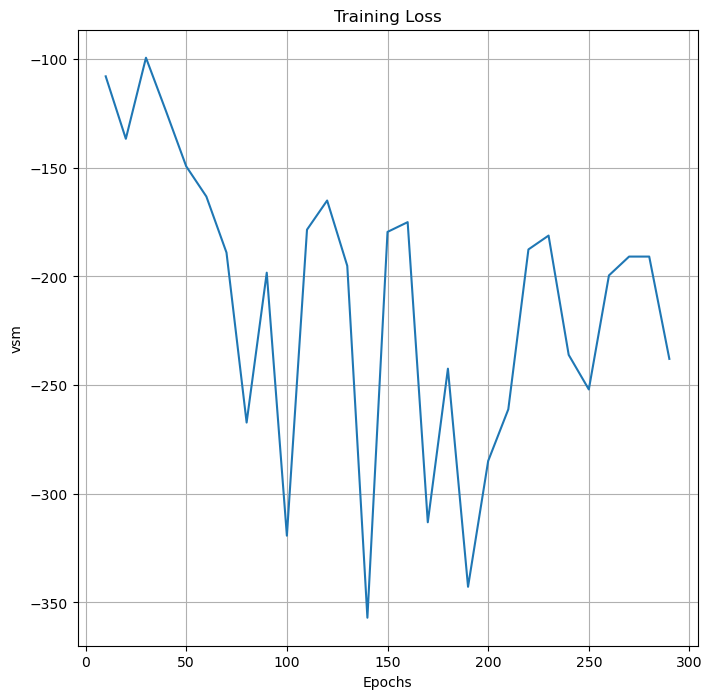

In [186]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [187]:
xs = pd.read_csv('Data/Ellipsoid'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/Ellipsoid'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [188]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.01, max_iter=1000)

In [189]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: -4.939958e-01 | T: ((Array([-1.0917253e-10,  2.7910016e-11,  1.0083272e-09, -3.4171208e-09,
       -2.5638576e-09,  4.3813642e-09, -3.1455075e-11,  4.2920129e-10,
        4.2749568e-10,  3.9694276e-11,  3.9277634e-09,  6.9046782e-11,
       -4.3742792e-09,  7.2960482e-10, -3.1158645e-09,  3.3260081e-10,
        3.0928113e-09,  1.0785163e-09, -3.8023670e-10,  4.0475205e-09],      dtype=float32), Array(0.20999993, dtype=float32)), Array([-0.04388859, -0.02793439,  0.14206074,  0.2739284 , -0.19410625,
        0.14439647, -0.3230423 , -0.00322333, -0.09705374, -0.02701462,
        0.04361032, -0.19424543,  0.00470992,  0.23105977, -0.04900626,
       -0.22515155,  0.05952124, -0.11318652,  0.19300802, -0.06804601,
        0.72433203], dtype=float32))
Step 1 | T: -7.772956e+00 | T: ((Array([ 0.00340361, -0.00263085, -0.0020014 ,  0.00322936, -0.00682568,
        0.00455791, -0.00952996,  0.00243522, -0.00997262,  0.0031542 ,
        0.00747424,  0.00918524, -0.0069945 ,  0.0087

Step 9 | T: -8.908179e+00 | T: ((Array([-0.01023415,  0.01638697,  0.01681235, -0.01337547, -0.00232179,
       -0.00793233, -0.00302442, -0.0122472 ,  0.00209319,  0.00600309,
        0.00694258, -0.00349667, -0.00369913,  0.00232009,  0.01114721,
        0.00397151,  0.01067643, -0.00579739,  0.00823997, -0.02760999],      dtype=float32), Array(0.25206923, dtype=float32)), Array([-0.16049236, -0.0472067 ,  0.18255769,  0.33161533, -0.23077229,
        0.12087291, -0.35139337, -0.05303002, -0.13271631, -0.06138626,
        0.08952927, -0.16045317,  0.00343058,  0.21107887, -0.00267143,
       -0.18034716,  0.09101754, -0.0513517 ,  0.1609291 , -0.00382271,
        0.68226635], dtype=float32))
Step 10 | T: -8.952850e+00 | T: ((Array([-0.01238908,  0.02172007,  0.02234839, -0.01755759, -0.00352978,
       -0.01032478, -0.00566184, -0.01521173,  0.00011556,  0.00831079,
        0.00954283, -0.001733  , -0.00530543,  0.00385059,  0.01501773,
        0.00374689,  0.01413246, -0.00817951,  

Step 21 | T: -1.036213e+01 | T: ((Array([-2.3856664e-10, -4.0013144e-09,  3.6335936e-09,  1.2718367e-09,
       -2.2768700e-09, -1.8827706e-09,  7.9153617e-10, -1.5623611e-09,
        1.2572604e-09, -4.6083382e-09,  1.5024200e-09, -5.8338792e-11,
       -2.7315228e-09, -1.8060366e-10,  1.3503124e-09, -3.6715895e-09,
        1.3030043e-11, -3.6636492e-09,  3.4738969e-11,  0.0000000e+00],      dtype=float32), Array(0.20993699, dtype=float32)), Array([-0.24027231, -0.08908287,  0.32574305,  0.48467493, -0.3343354 ,
        0.07480541, -0.40542355, -0.10994042, -0.17984259, -0.09059272,
        0.12635326, -0.08672901,  0.01083949,  0.16238701,  0.0342547 ,
       -0.07739367,  0.0842789 ,  0.02044948,  0.0967399 ,  0.0545197 ,
        0.42654938], dtype=float32))
Step 22 | T: -1.115302e+01 | T: ((Array([-1.4383229e-03,  3.5816138e-03,  3.3021411e-03, -1.6075763e-03,
       -2.5409623e-03,  5.6447898e-04,  2.6923805e-04, -3.2047803e-05,
        1.2877274e-03, -4.1194357e-06,  2.8068956e-03

Step 33 | T: -1.203332e+01 | T: ((Array([-0.00014599,  0.00528559,  0.00188403,  0.00092541, -0.00786802,
        0.00887181,  0.00067149,  0.0045727 , -0.00030293, -0.00238359,
        0.00655851, -0.00113404, -0.00672188,  0.0011665 ,  0.0081894 ,
       -0.00218184, -0.00024834, -0.00371205,  0.00135764, -0.02429879],      dtype=float32), Array(0.19635086, dtype=float32)), Array([-0.2917745 , -0.1027894 ,  0.38973016,  0.53937477, -0.3593705 ,
        0.02665962, -0.38643074, -0.12219273, -0.17339374, -0.10089374,
        0.13152589, -0.038098  ,  0.01279954,  0.12100844,  0.04756821,
       -0.01719702,  0.07110405,  0.03177427,  0.06328191,  0.07251841,
        0.2750999 ], dtype=float32))
Step 34 | T: -1.205017e+01 | T: ((Array([-0.00117099,  0.00701706,  0.00203929,  0.00159435, -0.01081785,
        0.01234678,  0.0012451 ,  0.00659657,  0.00028226, -0.00361459,
        0.00889784, -0.00115368, -0.00919141,  0.00153564,  0.01090927,
       -0.00358355, -0.00033488, -0.00510346, 

Step 45 | T: -1.205642e+01 | T: ((Array([-0.00216641,  0.0082829 , -0.00505681,  0.006241  , -0.0155983 ,
        0.0317406 ,  0.00124733,  0.00356648, -0.00013382, -0.0021259 ,
        0.01233769, -0.00137341, -0.01380277,  0.00121903,  0.01547787,
       -0.00080836, -0.00059981, -0.00574221,  0.00131282, -0.07652679],      dtype=float32), Array(0.19569792, dtype=float32)), Array([-0.2917745 , -0.1027894 ,  0.38973016,  0.53937477, -0.3593705 ,
        0.02665962, -0.38643074, -0.12219273, -0.17339374, -0.10089374,
        0.13152589, -0.038098  ,  0.01279954,  0.12100844,  0.04756821,
       -0.01719702,  0.07110405,  0.03177427,  0.06328191,  0.07251841,
        0.2750999 ], dtype=float32))
Step 46 | T: -1.206301e+01 | T: ((Array([-2.10420834e-03,  7.30991829e-03, -5.71702514e-03,  5.93374809e-03,
       -1.38673298e-02,  3.08878217e-02,  1.14949665e-03,  3.15408898e-03,
        2.71759200e-05, -2.95082573e-03,  1.10227661e-02, -1.25342340e-03,
       -1.24224825e-02,  1.18598714e-

Step 57 | T: -1.207537e+01 | T: ((Array([-0.00273332,  0.00598267, -0.00557598,  0.00356145, -0.01093139,
        0.01694998,  0.00194054,  0.00798723,  0.00042139, -0.00276531,
        0.00866496, -0.00068691, -0.00894671,  0.00158716,  0.00869575,
       -0.00204348, -0.00075472, -0.00562719,  0.00192382, -0.05060676],      dtype=float32), Array(0.19642197, dtype=float32)), Array([-0.2917745 , -0.1027894 ,  0.38973016,  0.53937477, -0.3593705 ,
        0.02665962, -0.38643074, -0.12219273, -0.17339374, -0.10089374,
        0.13152589, -0.038098  ,  0.01279954,  0.12100844,  0.04756821,
       -0.01719702,  0.07110405,  0.03177427,  0.06328191,  0.07251841,
        0.2750999 ], dtype=float32))
Step 58 | T: -1.207598e+01 | T: ((Array([-0.00245178,  0.00649687, -0.00514761,  0.00375946, -0.01193689,
        0.01664606,  0.00175486,  0.00729127,  0.00046461, -0.00318399,
        0.00939891, -0.00050569, -0.00974712,  0.00145232,  0.00942777,
       -0.00238709, -0.00076032, -0.00604084, 

Step 69 | T: -1.208373e+01 | T: ((Array([-0.00306148,  0.00673786, -0.00330351,  0.00520637, -0.01333787,
        0.02260712,  0.00207967,  0.00713087,  0.00077297, -0.00301274,
        0.01028801, -0.00073036, -0.01141546,  0.00161105,  0.01278538,
       -0.00305661, -0.0002996 , -0.00464644,  0.00173866, -0.04071949],      dtype=float32), Array(0.19584514, dtype=float32)), Array([-0.2917745 , -0.1027894 ,  0.38973016,  0.53937477, -0.3593705 ,
        0.02665962, -0.38643074, -0.12219273, -0.17339374, -0.10089374,
        0.13152589, -0.038098  ,  0.01279954,  0.12100844,  0.04756821,
       -0.01719702,  0.07110405,  0.03177427,  0.06328191,  0.07251841,
        0.2750999 ], dtype=float32))
Step 70 | T: -1.207253e+01 | T: ((Array([-0.00280919,  0.00647793, -0.0034667 ,  0.00509003, -0.01281885,
        0.0231359 ,  0.0019258 ,  0.00729709,  0.00089219, -0.00321852,
        0.00986691, -0.000872  , -0.01099367,  0.0015865 ,  0.01242737,
       -0.00321682, -0.00034355, -0.0045466 , 

Step 81 | T: -1.208309e+01 | T: ((Array([-0.00328689,  0.00683567, -0.00499205,  0.00435037, -0.01266584,
        0.02182761,  0.00221663,  0.00638438,  0.00101422, -0.00304842,
        0.01005744, -0.00106277, -0.01055359,  0.00162017,  0.01065479,
       -0.00296607, -0.00061224, -0.00591487,  0.00139167, -0.05195092],      dtype=float32), Array(0.19650133, dtype=float32)), Array([-0.2917745 , -0.1027894 ,  0.38973016,  0.53937477, -0.3593705 ,
        0.02665962, -0.38643074, -0.12219273, -0.17339374, -0.10089374,
        0.13152589, -0.038098  ,  0.01279954,  0.12100844,  0.04756821,
       -0.01719702,  0.07110405,  0.03177427,  0.06328191,  0.07251841,
        0.2750999 ], dtype=float32))
Step 82 | T: -1.208495e+01 | T: ((Array([-0.00322557,  0.00691391, -0.00496154,  0.00440056, -0.01291115,
        0.02142627,  0.0020855 ,  0.00653276,  0.00108768, -0.0030614 ,
        0.01022842, -0.00109341, -0.01078343,  0.00163977,  0.01083276,
       -0.00297974, -0.00057908, -0.00585242, 

Step 93 | T: -1.208279e+01 | T: ((Array([-0.00330857,  0.0066467 , -0.00410469,  0.0046265 , -0.01235145,
        0.02103845,  0.0021496 ,  0.00612313,  0.00115198, -0.00280345,
        0.00962168, -0.00100047, -0.01063387,  0.00160912,  0.01165305,
       -0.00301879, -0.00061415, -0.00518723,  0.00156764, -0.04990828],      dtype=float32), Array(0.19584417, dtype=float32)), Array([-0.2917745 , -0.1027894 ,  0.38973016,  0.53937477, -0.3593705 ,
        0.02665962, -0.38643074, -0.12219273, -0.17339374, -0.10089374,
        0.13152589, -0.038098  ,  0.01279954,  0.12100844,  0.04756821,
       -0.01719702,  0.07110405,  0.03177427,  0.06328191,  0.07251841,
        0.2750999 ], dtype=float32))
Step 94 | T: -1.208712e+01 | T: ((Array([-0.00331191,  0.00660032, -0.00410215,  0.00457807, -0.01225493,
        0.02126699,  0.00200776,  0.00618163,  0.00117936, -0.00279016,
        0.00956819, -0.00083624, -0.01051567,  0.00162137,  0.01155484,
       -0.00277593, -0.00062275, -0.0052955 , 

In [190]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0217 0.0096 0.0146 -0.0112 -0.0053 0.0620 0.0496 -0.0065 -0.1594 0.0667 0.0592 0.4248 0.5070 -0.1300 0.0140 -0.2420 -0.0253 0.2405 0.4790 -0.2602 -0.3008 )
T = 0.0365


In [191]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( -0.2918 -0.1028 0.3897 0.5394 -0.3594 0.0267 -0.3864 -0.1222 -0.1734 -0.1009 0.1315 -0.0381 0.0128 0.1210 0.0476 -0.0172 0.0711 0.0318 0.0633 0.0725 0.2751 )
T = 0.1963


In [192]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 1.4696 
 -T error = 0.0150


In [193]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 1.6129 
 -T error = 0.4635
Bridge Diffusion mean: 
 -mean error = 1.2041 
 -T error = 0.3037


In [194]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

KeyboardInterrupt: 

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# Cylinder

## Defining Manifold and Loading Score

In [195]:
M = Cylinder(params=(1.,jnp.array([0.,0.,1.]),jnp.pi/2.))
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)
x0[1]

using M.Exp for Logarithm


Array([0., 0.], dtype=float32)

In [206]:
file_path = 'scores/Cylinder/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), M.F(y))), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), M.F(y))), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [207]:
loss = jnp.load('scores/Cylinder/' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


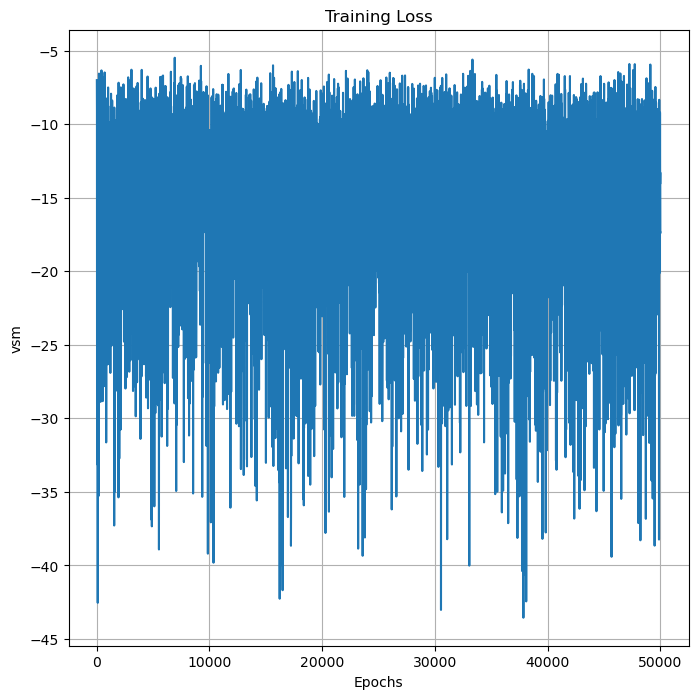

In [208]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [209]:
xs = pd.read_csv('Data/Cylinder/xs.csv', header=None)
charts = pd.read_csv('Data/Cylinder/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [210]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.1, max_iter=100)

In [211]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.253376e+01 | T: ((Array([ 0.20978732, -0.12701134], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.127123e+01 | T: ((Array([ 0.19984421, -0.11789317], dtype=float32), Array(0.21992658, dtype=float32)), Array([0., 0.], dtype=float32))
Final 1 | T: 1.127123e+01 | T: (Array([ 0.19984421, -0.11789317], dtype=float32), Array(0.21992658, dtype=float32))
Step 0 | T: 1.253376e+01 | T: ((Array([ 0.20978732, -0.12701134], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.127123e+01 | T: ((Array([ 0.19984421, -0.11789317], dtype=float32), Array(0.21992658, dtype=float32)), Array([0., 0.], dtype=float32))
Step 2 | T: 1.019969e+01 | T: ((Array([ 0.18999171, -0.11080638], dtype=float32), Array(0.2297391, dtype=float32)), Array([0., 0.], dtype=float32))
Step 3 | T: 9.286859e+00 | T: ((Array([ 0.1802602 , -0.10658575], dtype=float32), Array(0.23940282, dtype=float32)), Array([0., 0.], dtype=f

Step 54 | T: 2.622432e+00 | T: ((Array([-0.04554482, -0.11667   ], dtype=float32), Array(0.47981182, dtype=float32)), Array([0., 0.], dtype=float32))
Step 55 | T: 2.611824e+00 | T: ((Array([-0.04651392, -0.11656349], dtype=float32), Array(0.48178506, dtype=float32)), Array([0., 0.], dtype=float32))
Step 56 | T: 2.601625e+00 | T: ((Array([-0.04743124, -0.11652292], dtype=float32), Array(0.48372135, dtype=float32)), Array([0., 0.], dtype=float32))
Step 57 | T: 2.591809e+00 | T: ((Array([-0.0482995 , -0.11654418], dtype=float32), Array(0.4856224, dtype=float32)), Array([0., 0.], dtype=float32))
Step 58 | T: 2.582353e+00 | T: ((Array([-0.04912129, -0.11662061], dtype=float32), Array(0.48748988, dtype=float32)), Array([0., 0.], dtype=float32))
Step 59 | T: 2.573236e+00 | T: ((Array([-0.04989908, -0.11674349], dtype=float32), Array(0.48932528, dtype=float32)), Array([0., 0.], dtype=float32))
Step 60 | T: 2.564438e+00 | T: ((Array([-0.0506352 , -0.11690269], dtype=float32), Array(0.49113005, 

Step 10 | T: 5.604968e+00 | T: ((Array([ 0.11738792, -0.11944178], dtype=float32), Array(0.3010615, dtype=float32)), Array([0., 0.], dtype=float32))
Step 11 | T: 5.312989e+00 | T: ((Array([ 0.10933157, -0.12195447], dtype=float32), Array(0.30887944, dtype=float32)), Array([0., 0.], dtype=float32))
Step 12 | T: 5.055677e+00 | T: ((Array([ 0.10153141, -0.12389287], dtype=float32), Array(0.31643915, dtype=float32)), Array([0., 0.], dtype=float32))
Step 13 | T: 4.828106e+00 | T: ((Array([ 0.09399057, -0.12518921], dtype=float32), Array(0.32374248, dtype=float32)), Array([0., 0.], dtype=float32))
Step 14 | T: 4.626137e+00 | T: ((Array([ 0.08671059, -0.12583841], dtype=float32), Array(0.33079267, dtype=float32)), Array([0., 0.], dtype=float32))
Step 15 | T: 4.446292e+00 | T: ((Array([ 0.0796916 , -0.12588406], dtype=float32), Array(0.3375941, dtype=float32)), Array([0., 0.], dtype=float32))
Step 16 | T: 4.285638e+00 | T: ((Array([ 0.07293245, -0.12540343], dtype=float32), Array(0.3441521, dt

Step 65 | T: 2.524661e+00 | T: ((Array([-0.05376468, -0.11786336], dtype=float32), Array(0.49973878, dtype=float32)), Array([0., 0.], dtype=float32))
Step 66 | T: 2.517447e+00 | T: ((Array([-0.05429367, -0.11802062], dtype=float32), Array(0.50138533, dtype=float32)), Array([0., 0.], dtype=float32))
Step 67 | T: 2.510452e+00 | T: ((Array([-0.05479435, -0.11814969], dtype=float32), Array(0.50300914, dtype=float32)), Array([0., 0.], dtype=float32))
Step 68 | T: 2.503664e+00 | T: ((Array([-0.05526825, -0.11824697], dtype=float32), Array(0.5046111, dtype=float32)), Array([0., 0.], dtype=float32))
Step 69 | T: 2.497075e+00 | T: ((Array([-0.05571681, -0.1183107 ], dtype=float32), Array(0.5061919, dtype=float32)), Array([0., 0.], dtype=float32))
Step 70 | T: 2.490674e+00 | T: ((Array([-0.05614142, -0.11834089], dtype=float32), Array(0.5077524, dtype=float32)), Array([0., 0.], dtype=float32))
Step 71 | T: 2.484454e+00 | T: ((Array([-0.05654337, -0.11833919], dtype=float32), Array(0.5092934, dty

Step 21 | T: 3.695277e+00 | T: ((Array([ 0.04292765, -0.11873787], dtype=float32), Array(0.3735191, dtype=float32)), Array([0., 0.], dtype=float32))
Step 22 | T: 3.608744e+00 | T: ((Array([ 0.03765313, -0.1172755 ], dtype=float32), Array(0.37875897, dtype=float32)), Array([0., 0.], dtype=float32))
Step 23 | T: 3.529991e+00 | T: ((Array([ 0.03260764, -0.11596888], dtype=float32), Array(0.3838056, dtype=float32)), Array([0., 0.], dtype=float32))
Step 24 | T: 3.458144e+00 | T: ((Array([ 0.02778482, -0.11487352], dtype=float32), Array(0.3886668, dtype=float32)), Array([0., 0.], dtype=float32))
Step 25 | T: 3.392440e+00 | T: ((Array([ 0.02317804, -0.11402719], dtype=float32), Array(0.3933503, dtype=float32)), Array([0., 0.], dtype=float32))
Step 26 | T: 3.332210e+00 | T: ((Array([ 0.01878055, -0.11344999], dtype=float32), Array(0.39786372, dtype=float32)), Array([0., 0.], dtype=float32))
Step 27 | T: 3.276871e+00 | T: ((Array([ 0.01458543, -0.11314545], dtype=float32), Array(0.40221456, dty

Step 77 | T: 2.450500e+00 | T: ((Array([-0.05854378, -0.1178904 ], dtype=float32), Array(0.51816314, dtype=float32)), Array([0., 0.], dtype=float32))
Step 78 | T: 2.445343e+00 | T: ((Array([-0.05881813, -0.11779167], dtype=float32), Array(0.5195839, dtype=float32)), Array([0., 0.], dtype=float32))
Step 79 | T: 2.440315e+00 | T: ((Array([-0.059078 , -0.1176997], dtype=float32), Array(0.5209895, dtype=float32)), Array([0., 0.], dtype=float32))
Step 80 | T: 2.435411e+00 | T: ((Array([-0.05932418, -0.11761835], dtype=float32), Array(0.52238035, dtype=float32)), Array([0., 0.], dtype=float32))
Step 81 | T: 2.430626e+00 | T: ((Array([-0.05955741, -0.1175506 ], dtype=float32), Array(0.5237569, dtype=float32)), Array([0., 0.], dtype=float32))
Step 82 | T: 2.425956e+00 | T: ((Array([-0.05977839, -0.1174985 ], dtype=float32), Array(0.52511954, dtype=float32)), Array([0., 0.], dtype=float32))
Step 83 | T: 2.421397e+00 | T: ((Array([-0.0599878 , -0.11746314], dtype=float32), Array(0.5264686, dtype

Step 33 | T: 3.022899e+00 | T: ((Array([-0.00672597, -0.11571104], dtype=float32), Array(0.42530316, dtype=float32)), Array([0., 0.], dtype=float32))
Step 34 | T: 2.990475e+00 | T: ((Array([-0.00969885, -0.11650418], dtype=float32), Array(0.42871022, dtype=float32)), Array([0., 0.], dtype=float32))
Step 35 | T: 2.960207e+00 | T: ((Array([-0.01252409, -0.11728658], dtype=float32), Array(0.43200752, dtype=float32)), Array([0., 0.], dtype=float32))
Step 36 | T: 2.931899e+00 | T: ((Array([-0.01520805, -0.11802095], dtype=float32), Array(0.43520057, dtype=float32)), Array([0., 0.], dtype=float32))
Step 37 | T: 2.905380e+00 | T: ((Array([-0.01775693, -0.11867595], dtype=float32), Array(0.43829468, dtype=float32)), Array([0., 0.], dtype=float32))
Step 38 | T: 2.880492e+00 | T: ((Array([-0.02017676, -0.11922707], dtype=float32), Array(0.4412949, dtype=float32)), Array([0., 0.], dtype=float32))
Step 39 | T: 2.857095e+00 | T: ((Array([-0.02247341, -0.11965715], dtype=float32), Array(0.4442061, d

Step 89 | T: 2.396170e+00 | T: ((Array([-0.06103403, -0.11755958], dtype=float32), Array(0.5342948, dtype=float32)), Array([0., 0.], dtype=float32))
Step 90 | T: 2.392290e+00 | T: ((Array([-0.06117819, -0.11760775], dtype=float32), Array(0.53555715, dtype=float32)), Array([0., 0.], dtype=float32))
Step 91 | T: 2.388495e+00 | T: ((Array([-0.06131494, -0.11765787], dtype=float32), Array(0.5368082, dtype=float32)), Array([0., 0.], dtype=float32))
Step 92 | T: 2.384783e+00 | T: ((Array([-0.06144467, -0.11770729], dtype=float32), Array(0.5380481, dtype=float32)), Array([0., 0.], dtype=float32))
Step 93 | T: 2.381150e+00 | T: ((Array([-0.06156776, -0.11775362], dtype=float32), Array(0.53927714, dtype=float32)), Array([0., 0.], dtype=float32))
Step 94 | T: 2.377595e+00 | T: ((Array([-0.06168457, -0.11779487], dtype=float32), Array(0.54049546, dtype=float32)), Array([0., 0.], dtype=float32))
Step 95 | T: 2.374115e+00 | T: ((Array([-0.06179544, -0.11782947], dtype=float32), Array(0.5417033, dty

Step 45 | T: 2.741758e+00 | T: ((Array([-0.03397036, -0.11962096], dtype=float32), Array(0.46004456, dtype=float32)), Array([0., 0.], dtype=float32))
Step 46 | T: 2.725882e+00 | T: ((Array([-0.03555271, -0.1192845 ], dtype=float32), Array(0.46244863, dtype=float32)), Array([0., 0.], dtype=float32))
Step 47 | T: 2.710775e+00 | T: ((Array([-0.0370519, -0.1189051], dtype=float32), Array(0.4647944, dtype=float32)), Array([0., 0.], dtype=float32))
Step 48 | T: 2.696382e+00 | T: ((Array([-0.03847208, -0.11850479], dtype=float32), Array(0.46708483, dtype=float32)), Array([0., 0.], dtype=float32))
Step 49 | T: 2.682651e+00 | T: ((Array([-0.03981722, -0.11810457], dtype=float32), Array(0.46932274, dtype=float32)), Array([0., 0.], dtype=float32))
Step 50 | T: 2.669535e+00 | T: ((Array([-0.04109114, -0.11772352], dtype=float32), Array(0.47151077, dtype=float32)), Array([0., 0.], dtype=float32))
Step 51 | T: 2.656993e+00 | T: ((Array([-0.04229747, -0.11737809], dtype=float32), Array(0.4736514, dty

Step 1 | T: 1.127123e+01 | T: ((Array([ 0.19984421, -0.11789317], dtype=float32), Array(0.21992658, dtype=float32)), Array([0., 0.], dtype=float32))
Step 2 | T: 1.019969e+01 | T: ((Array([ 0.18999171, -0.11080638], dtype=float32), Array(0.2297391, dtype=float32)), Array([0., 0.], dtype=float32))
Step 3 | T: 9.286859e+00 | T: ((Array([ 0.1802602 , -0.10658575], dtype=float32), Array(0.23940282, dtype=float32)), Array([0., 0.], dtype=float32))
Step 4 | T: 8.505708e+00 | T: ((Array([ 0.17067672, -0.10507598], dtype=float32), Array(0.24888873, dtype=float32)), Array([0., 0.], dtype=float32))
Step 5 | T: 7.834294e+00 | T: ((Array([ 0.16126491, -0.10560046], dtype=float32), Array(0.25817323, dtype=float32)), Array([0., 0.], dtype=float32))
Step 6 | T: 7.254978e+00 | T: ((Array([ 0.1520451 , -0.10748912], dtype=float32), Array(0.2672376, dtype=float32)), Array([0., 0.], dtype=float32))
Step 7 | T: 6.753355e+00 | T: ((Array([ 0.1430345 , -0.11020492], dtype=float32), Array(0.27606753, dtype=fl

Step 57 | T: 2.591809e+00 | T: ((Array([-0.0482995 , -0.11654418], dtype=float32), Array(0.4856224, dtype=float32)), Array([0., 0.], dtype=float32))
Step 58 | T: 2.582353e+00 | T: ((Array([-0.04912129, -0.11662061], dtype=float32), Array(0.48748988, dtype=float32)), Array([0., 0.], dtype=float32))
Step 59 | T: 2.573236e+00 | T: ((Array([-0.04989908, -0.11674349], dtype=float32), Array(0.48932528, dtype=float32)), Array([0., 0.], dtype=float32))
Step 60 | T: 2.564438e+00 | T: ((Array([-0.0506352 , -0.11690269], dtype=float32), Array(0.49113005, dtype=float32)), Array([0., 0.], dtype=float32))
Step 61 | T: 2.555943e+00 | T: ((Array([-0.05133187, -0.11708724], dtype=float32), Array(0.49290553, dtype=float32)), Array([0., 0.], dtype=float32))
Step 62 | T: 2.547732e+00 | T: ((Array([-0.0519912 , -0.11728597], dtype=float32), Array(0.494653, dtype=float32)), Array([0., 0.], dtype=float32))
Step 63 | T: 2.539791e+00 | T: ((Array([-0.0526152 , -0.11748803], dtype=float32), Array(0.49637362, dt

Step 13 | T: 4.828106e+00 | T: ((Array([ 0.09399057, -0.12518921], dtype=float32), Array(0.32374248, dtype=float32)), Array([0., 0.], dtype=float32))
Step 14 | T: 4.626137e+00 | T: ((Array([ 0.08671059, -0.12583841], dtype=float32), Array(0.33079267, dtype=float32)), Array([0., 0.], dtype=float32))
Step 15 | T: 4.446292e+00 | T: ((Array([ 0.0796916 , -0.12588406], dtype=float32), Array(0.3375941, dtype=float32)), Array([0., 0.], dtype=float32))
Step 16 | T: 4.285638e+00 | T: ((Array([ 0.07293245, -0.12540343], dtype=float32), Array(0.3441521, dtype=float32)), Array([0., 0.], dtype=float32))
Step 17 | T: 4.141697e+00 | T: ((Array([ 0.06643098, -0.12449438], dtype=float32), Array(0.35047266, dtype=float32)), Array([0., 0.], dtype=float32))
Step 18 | T: 4.012366e+00 | T: ((Array([ 0.06018403, -0.12326495], dtype=float32), Array(0.35656244, dtype=float32)), Array([0., 0.], dtype=float32))
Step 19 | T: 3.895845e+00 | T: ((Array([ 0.05418767, -0.12182567], dtype=float32), Array(0.3624285, dt

Step 69 | T: 2.497075e+00 | T: ((Array([-0.05571681, -0.1183107 ], dtype=float32), Array(0.5061919, dtype=float32)), Array([0., 0.], dtype=float32))
Step 70 | T: 2.490674e+00 | T: ((Array([-0.05614142, -0.11834089], dtype=float32), Array(0.5077524, dtype=float32)), Array([0., 0.], dtype=float32))
Step 71 | T: 2.484454e+00 | T: ((Array([-0.05654337, -0.11833919], dtype=float32), Array(0.5092934, dtype=float32)), Array([0., 0.], dtype=float32))
Step 72 | T: 2.478405e+00 | T: ((Array([-0.0569239 , -0.11830863], dtype=float32), Array(0.51081544, dtype=float32)), Array([0., 0.], dtype=float32))
Step 73 | T: 2.472522e+00 | T: ((Array([-0.05728416, -0.11825338], dtype=float32), Array(0.5123192, dtype=float32)), Array([0., 0.], dtype=float32))
Step 74 | T: 2.466795e+00 | T: ((Array([-0.05762527, -0.11817839], dtype=float32), Array(0.5138053, dtype=float32)), Array([0., 0.], dtype=float32))
Step 75 | T: 2.461220e+00 | T: ((Array([-0.05794826, -0.11808914], dtype=float32), Array(0.51527435, dtyp

Step 25 | T: 3.392440e+00 | T: ((Array([ 0.02317804, -0.11402719], dtype=float32), Array(0.3933503, dtype=float32)), Array([0., 0.], dtype=float32))
Step 26 | T: 3.332210e+00 | T: ((Array([ 0.01878055, -0.11344999], dtype=float32), Array(0.39786372, dtype=float32)), Array([0., 0.], dtype=float32))
Step 27 | T: 3.276871e+00 | T: ((Array([ 0.01458543, -0.11314545], dtype=float32), Array(0.40221456, dtype=float32)), Array([0., 0.], dtype=float32))
Step 28 | T: 3.225912e+00 | T: ((Array([ 0.01058569, -0.11310241], dtype=float32), Array(0.4064102, dtype=float32)), Array([0., 0.], dtype=float32))
Step 29 | T: 3.178887e+00 | T: ((Array([ 0.00677436, -0.11329741], dtype=float32), Array(0.41045776, dtype=float32)), Array([0., 0.], dtype=float32))
Step 30 | T: 3.135400e+00 | T: ((Array([ 0.00314443, -0.11369742], dtype=float32), Array(0.41436422, dtype=float32)), Array([0., 0.], dtype=float32))
Step 31 | T: 3.095105e+00 | T: ((Array([-0.00031104, -0.11426259], dtype=float32), Array(0.4181363, dt

Step 81 | T: 2.430626e+00 | T: ((Array([-0.05955741, -0.1175506 ], dtype=float32), Array(0.5237569, dtype=float32)), Array([0., 0.], dtype=float32))
Step 82 | T: 2.425956e+00 | T: ((Array([-0.05977839, -0.1174985 ], dtype=float32), Array(0.52511954, dtype=float32)), Array([0., 0.], dtype=float32))
Step 83 | T: 2.421397e+00 | T: ((Array([-0.0599878 , -0.11746314], dtype=float32), Array(0.5264686, dtype=float32)), Array([0., 0.], dtype=float32))
Step 84 | T: 2.416945e+00 | T: ((Array([-0.06018626, -0.11744468], dtype=float32), Array(0.5278043, dtype=float32)), Array([0., 0.], dtype=float32))
Step 85 | T: 2.412597e+00 | T: ((Array([-0.06037437, -0.11744244], dtype=float32), Array(0.5291271, dtype=float32)), Array([0., 0.], dtype=float32))
Step 86 | T: 2.408349e+00 | T: ((Array([-0.06055268, -0.11745503], dtype=float32), Array(0.5304373, dtype=float32)), Array([0., 0.], dtype=float32))
Step 87 | T: 2.404197e+00 | T: ((Array([-0.06072173, -0.11748043], dtype=float32), Array(0.5317351, dtype

Step 37 | T: 2.905380e+00 | T: ((Array([-0.01775693, -0.11867595], dtype=float32), Array(0.43829468, dtype=float32)), Array([0., 0.], dtype=float32))
Step 38 | T: 2.880492e+00 | T: ((Array([-0.02017676, -0.11922707], dtype=float32), Array(0.4412949, dtype=float32)), Array([0., 0.], dtype=float32))
Step 39 | T: 2.857095e+00 | T: ((Array([-0.02247341, -0.11965715], dtype=float32), Array(0.4442061, dtype=float32)), Array([0., 0.], dtype=float32))
Step 40 | T: 2.835063e+00 | T: ((Array([-0.02465253, -0.11995652], dtype=float32), Array(0.4470328, dtype=float32)), Array([0., 0.], dtype=float32))
Step 41 | T: 2.814281e+00 | T: ((Array([-0.0267196 , -0.12012272], dtype=float32), Array(0.44977942, dtype=float32)), Array([0., 0.], dtype=float32))
Step 42 | T: 2.794647e+00 | T: ((Array([-0.02867992, -0.12015998], dtype=float32), Array(0.45245007, dtype=float32)), Array([0., 0.], dtype=float32))
Step 43 | T: 2.776069e+00 | T: ((Array([-0.03053858, -0.12007831], dtype=float32), Array(0.4550487, dty

Step 93 | T: 2.381150e+00 | T: ((Array([-0.06156776, -0.11775362], dtype=float32), Array(0.53927714, dtype=float32)), Array([0., 0.], dtype=float32))
Step 94 | T: 2.377595e+00 | T: ((Array([-0.06168457, -0.11779487], dtype=float32), Array(0.54049546, dtype=float32)), Array([0., 0.], dtype=float32))
Step 95 | T: 2.374115e+00 | T: ((Array([-0.06179544, -0.11782947], dtype=float32), Array(0.5417033, dtype=float32)), Array([0., 0.], dtype=float32))
Step 96 | T: 2.370709e+00 | T: ((Array([-0.06190068, -0.11785634], dtype=float32), Array(0.5429008, dtype=float32)), Array([0., 0.], dtype=float32))
Step 97 | T: 2.367373e+00 | T: ((Array([-0.06200058, -0.11787486], dtype=float32), Array(0.5440882, dtype=float32)), Array([0., 0.], dtype=float32))
Step 98 | T: 2.364108e+00 | T: ((Array([-0.06209545, -0.11788491], dtype=float32), Array(0.5452656, dtype=float32)), Array([0., 0.], dtype=float32))
Step 99 | T: 2.360909e+00 | T: ((Array([-0.06218554, -0.11788679], dtype=float32), Array(0.54643327, dty

In [212]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.0733 -0.1158 )
T = 0.5287


In [213]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0000 0.0000 )
T = 0.5464


In [214]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.1371 
 -T error = 0.0177


In [215]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.1371 
 -T error = 0.0287
Bridge Diffusion mean: 
 -mean error = 0.0000 
 -T error = 0.0464


In [ ]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# Torus

## Defining Manifold and Loading Score

In [216]:
M = Torus()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [217]:
file_path = 'scores/Torus/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), M.F(y))), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), M.F(y))), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [218]:
loss = jnp.load('scores/Torus/' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


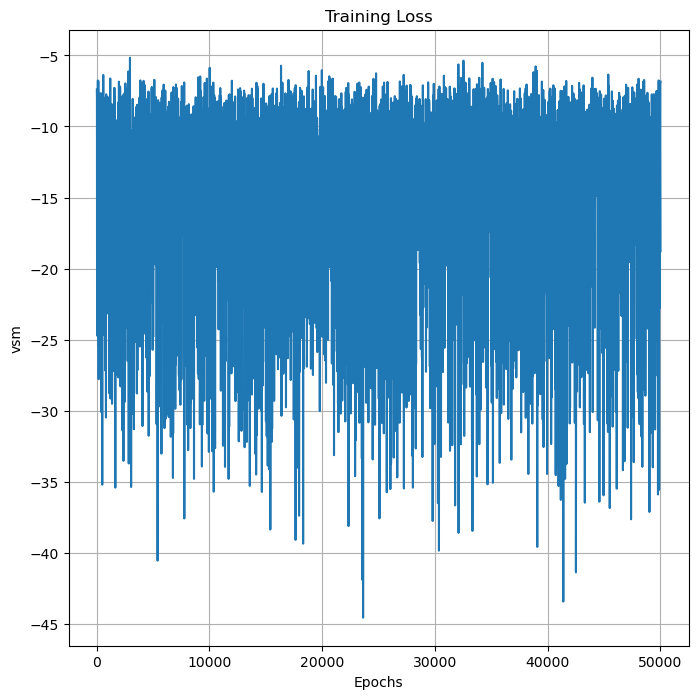

In [219]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [222]:
xs = pd.read_csv('Data/Torus/xs.csv', header=None)
charts = pd.read_csv('Data/Torus/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [228]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.1, max_iter=100)

In [229]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 8.842886e+00 | T: ((Array([ 0.00067029, -0.0724843 ], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 7.843040e+00 | T: ((Array([-0.00861051, -0.08232511], dtype=float32), Array(0.21992584, dtype=float32)), Array([0., 0.], dtype=float32))
Final 1 | T: 7.843040e+00 | T: (Array([-0.00861051, -0.08232511], dtype=float32), Array(0.21992584, dtype=float32))
Step 0 | T: 8.842617e+00 | T: ((Array([ 0.00067029, -0.0724843 ], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 7.842509e+00 | T: ((Array([-0.00861051, -0.08232684], dtype=float32), Array(0.21992582, dtype=float32)), Array([0., 0.], dtype=float32))
Step 2 | T: 7.012611e+00 | T: ((Array([-0.01626482, -0.09188902], dtype=float32), Array(0.22973791, dtype=float32)), Array([0., 0.], dtype=float32))
Step 3 | T: 6.318608e+00 | T: ((Array([-0.02147868, -0.10104105], dtype=float32), Array(0.23940323, dtype=float32)), Array([0., 0.], dtype=

Step 53 | T: 1.238400e+00 | T: ((Array([-0.01052028, -0.11484088], dtype=float32), Array(0.4779302, dtype=float32)), Array([0., 0.], dtype=float32))
Step 54 | T: 1.230190e+00 | T: ((Array([-0.01085292, -0.11534043], dtype=float32), Array(0.47988865, dtype=float32)), Array([0., 0.], dtype=float32))
Step 55 | T: 1.222097e+00 | T: ((Array([-0.01115694, -0.11582392], dtype=float32), Array(0.48180634, dtype=float32)), Array([0., 0.], dtype=float32))
Step 56 | T: 1.215227e+00 | T: ((Array([-0.01142199, -0.11628516], dtype=float32), Array(0.48368523, dtype=float32)), Array([0., 0.], dtype=float32))
Step 57 | T: 1.207723e+00 | T: ((Array([-0.01164028, -0.11671952], dtype=float32), Array(0.48552707, dtype=float32)), Array([0., 0.], dtype=float32))
Step 58 | T: 1.199955e+00 | T: ((Array([-0.01180675, -0.11712455], dtype=float32), Array(0.48733345, dtype=float32)), Array([0., 0.], dtype=float32))
Step 59 | T: 1.193341e+00 | T: ((Array([-0.011919  , -0.11749344], dtype=float32), Array(0.48910597, 

In [230]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0117 -0.1428 )
T = 0.4576


In [231]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0000 0.0000 )
T = 0.5428


In [232]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.1433 
 -T error = 0.0852


In [233]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.1433 
 -T error = 0.0424
Bridge Diffusion mean: 
 -mean error = 0.0000 
 -T error = 0.0428


In [ ]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# Hyperbolic Parabolid

## Defining Manifold and Loading Score

In [234]:
M = HypParaboloid()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [235]:
file_path = 'scores/HypParaboloid/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [236]:
loss = jnp.load('scores/HypParaboloid/' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


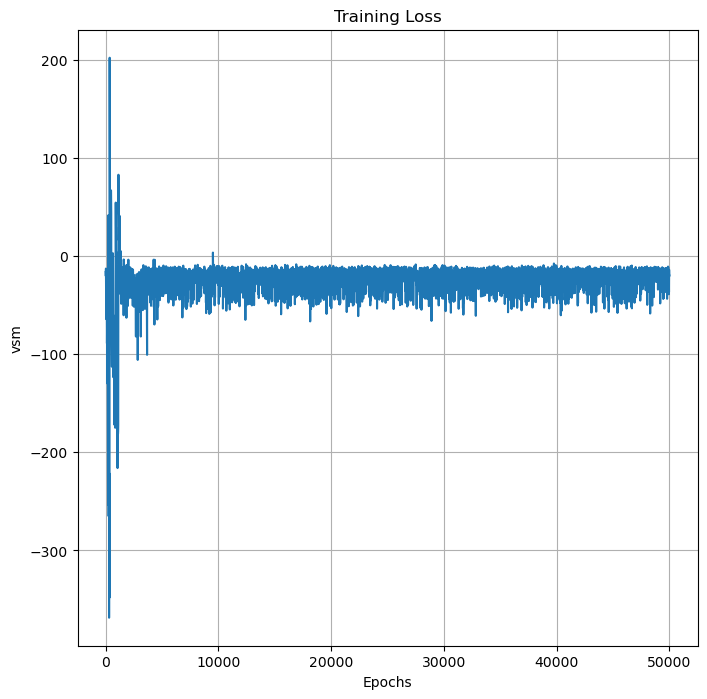

In [237]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [239]:
xs = pd.read_csv('Data/HypParaboloid/xs.csv', header=None)
charts = pd.read_csv('Data/HypParaboloid/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [251]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.001, max_iter=1000)

In [241]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [242]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0000 )
T = 1.0000


In [243]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0000 0.0000 )
T = 0.5428


In [244]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0000 
 -T error = 0.4572


In [245]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.0000 
 -T error = 0.5000
Bridge Diffusion mean: 
 -mean error = 0.0000 
 -T error = 0.0428


In [253]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

426 ms ± 7.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# SPDN

## Defining Manifold and Loading Score

In [273]:
N = 2

In [274]:
M = SPDN(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([1.]*(N*(N+1)//2))

using M.Exp for Logarithm


In [275]:
file_path = 'scores/SPDN'+str(N)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [277]:
loss = jnp.load('scores/SPDN'+str(N)+'/'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  360


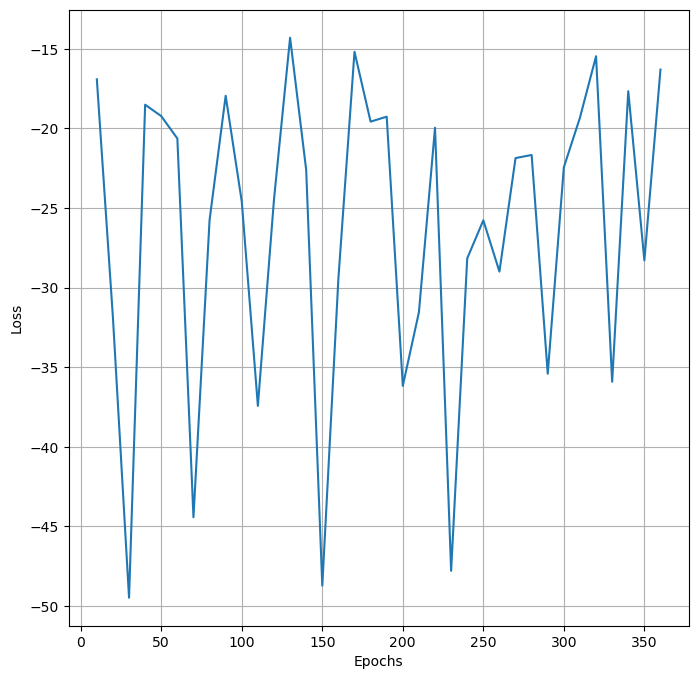

In [278]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [279]:
xs = pd.read_csv('Data/SPDN'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/SPDN'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [280]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=100)
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

785 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [283]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.7097 
 -T error = 0.0779


In [287]:
test_data = jnp.array([1.0,0.0,1.0])

Array([[1., 0.],
       [0., 1.]], dtype=float32)

# Landmarks

## Defining Manifold and Loading Score

In [169]:
N = 2

In [170]:
M = Landmarks(N=N,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.linspace(5.0,-5.0,M.N))).T.flatten())
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.zeros(M.N))).T.flatten())

using M.Exp for Logarithm


In [171]:
file_path = 'scores/Landmarks'+str(N)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [172]:
loss = jnp.load('scores/Landmarks'+str(N)+'/'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  10


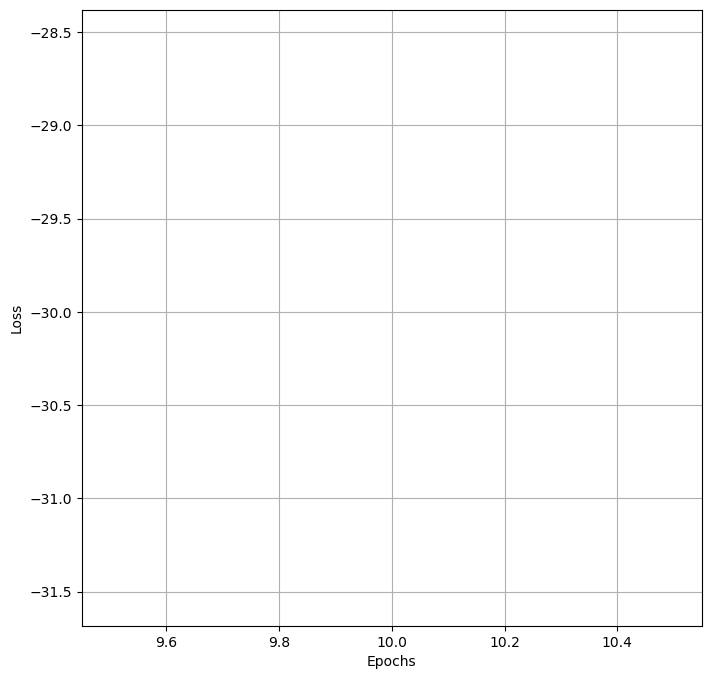

In [173]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [155]:
xs = pd.read_csv('Data/Landmarks'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/Landmarks'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [156]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=100)
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

1.14 s ± 95.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -5.0491 0.0153 5.0668 -0.0962 )
T = 0.5009


In [109]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgex[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:


NameError: name 'mu_bridgex' is not defined

In [110]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[0]), ")")
print(f"T = {T_opt:.4f}")

Score Matching Riemannian Diffusion Mean:


NameError: name 'mu_opt' is not defined

In [147]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_bridgex[-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.3090 
 -T error = 0.0363


NameError: name 'mu_bridgex' is not defined

# MNIST

## Defining Manifold and Loading Score

In [291]:
s1_path = ''.join(('scores/MNIST/',loss_type,'/'))
s2_path = 'scores/MNIST/s2/'

ds = load_mnist("train", 100, 2712)

state = load_model('ManLearn/models/MNIST/VAE/')
F = lambda x: mnist_decoder.apply(state.params, state.rng_key, x[0]).reshape(-1)

M = Latent(F=F,dim=2,emb_dim=28*28,invF=None)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)

N_dim = M.dim
x0 = mnist_encoder.apply(state.params, state.rng_key, next(ds).image)
x0 = M.coords(x0[0])

layers = [50,100,200,400,400,200,100,50]

s1_model = hk.transform(lambda x: models.MLP_s1(dim=N_dim, layers=layers)(x))
s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=N_dim, r = max(N_dim//2,1))(x))

using M.Exp for Logarithm


In [314]:
rng_key = jax.random.PRNGKey(2712)
s1_state = load_model(s1_path)
def grady_log(x,y,t):
    
    return s1.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [315]:
loss = jnp.load('scores/MNIST/'+loss_type+'/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  30


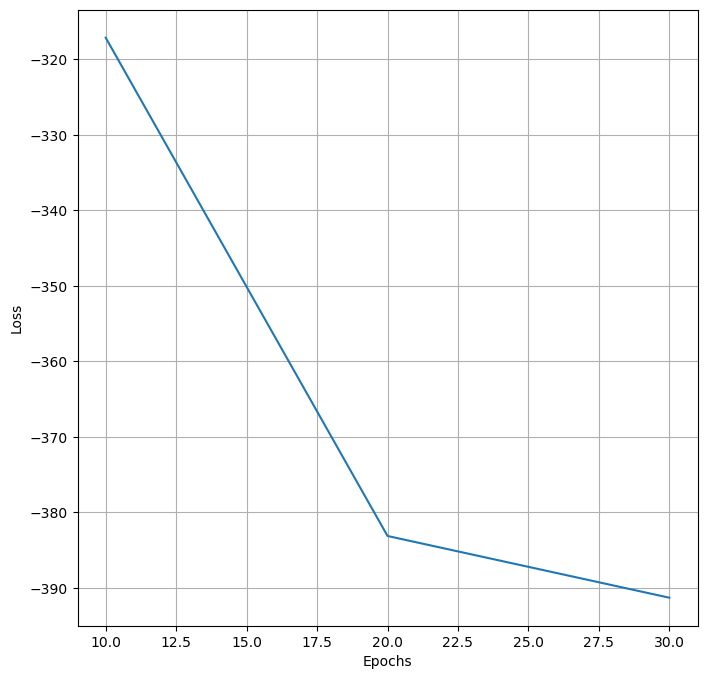

In [316]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [317]:
xs = pd.read_csv('Data/VAE_MNIST/xs.csv', header=None)
charts = pd.read_csv('Data/VAE_MNIST/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [329]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=100)

In [330]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 1.3498 
 -T error = 0.2722


In [ ]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)